Flow cytometry data from twelve strains of E. Coli expressing engineering histidine kinases are pooled together as the master dataset. For simulations, data points are sampled from this master dataset.

#Prepare Environment

FLACS sorts cell at a per celll level

In [1]:
DIRPATH_SDS = '/content/SimulateDSorting'

import os
if os.path.exists(DIRPATH_SDS):
  !rm -rf {DIRPATH_SDS}

%load_ext autoreload

In [2]:
%%capture
if not os.path.exists(DIRPATH_SDS):
  !git clone https://github.com/Herais/SimulateDSorting.git
  !chmod +x {DIRPATH_SDS}/setup_environment.sh
  os.chdir(DIRPATH_SDS)
  !{DIRPATH_SDS}/setup_environment.sh

In [3]:
!git pull https://github.com/Herais/SimulateDSorting.git

From https://github.com/Herais/SimulateDSorting
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


In [4]:
!git stash

Saved working directory and index state WIP on main: 2418665 ds


In [5]:
#Load Global Libraries
import os
import sys
import shutil
import itertools

import flowkit as fk

import bokeh
from bokeh.plotting import figure, output_file, save
from bokeh.models import *
from bokeh.plotting import show
from bokeh.layouts import gridplot
from bokeh.layouts import row
from bokeh.models import Range1d
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from bokeh.io import export_png

from sklearn.datasets import make_blobs
import colorcet as cc
import seaborn as sns

import numpy as np
import pandas as pd
import math
import random
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import Counter
from scipy.signal import find_peaks

import re

rng = np.random.default_rng(seed=None)

bokeh.io.output_notebook()
%matplotlib inline

print('flowkit verion: ', fk.__version__)
print('bokeh version: ', bokeh.__version__)
print('pandas verion: ', pd.__version__)

flowkit verion:  1.0.1
bokeh version:  2.4.3
pandas verion:  1.5.3


In [6]:
# Load Local Libraries
os.chdir("{}/module".format(DIRPATH_SDS))

%autoreload 2

from Data import FlowData
from Droplet import Droplet
from FACS import Flowcytometry
from Dsort import DropletSorter

# Prepare flowcytometry data for sampling

In [7]:
# Define Directory path for Flow data
DIRPATH_FLOWDATA = "/content/flowdata"

# Delect DIRPATH_FLOWDATA if it exists to start clean
!rm -rf {DIRPATH_FLOWDATA}

In [8]:
# Download from shared googledrive link
import gdown
import os

# download zipped file
# id_folder is the from the link of the Google Drive Shared Folder
# the fcs files are already unzipped in the folder
id_folder = "19MeVT4zKAsTtGdLwQjj6xBtj59Q9x2No"

gdown.download_folder(id=id_folder, output=DIRPATH_FLOWDATA, quiet=True)

['/content/flowdata/AKH_VX_20230328_library_isolates_A1_MAIPTG.fcs',
 '/content/flowdata/AKH_VX_20230328_library_isolates_A1_MAIPTGZ.fcs',
 '/content/flowdata/AKH_VX_20230328_library_isolates_A6_MAIPTG.fcs',
 '/content/flowdata/AKH_VX_20230328_library_isolates_A6_MAIPTGZ.fcs',
 '/content/flowdata/AKH_VX_20230328_library_isolates_B3_MAIPTG.fcs',
 '/content/flowdata/AKH_VX_20230328_library_isolates_B3_MAIPTGZ.fcs',
 '/content/flowdata/AKH_VX_20230328_library_isolates_B5_MAIPTG.fcs',
 '/content/flowdata/AKH_VX_20230328_library_isolates_B5_MAIPTGZ.fcs',
 '/content/flowdata/AKH_VX_20230328_library_isolates_C3_MAIPTG.fcs',
 '/content/flowdata/AKH_VX_20230328_library_isolates_C3_MAIPTGZ.fcs',
 '/content/flowdata/AKH_VX_20230328_library_isolates_C4_MAIPTG.fcs',
 '/content/flowdata/AKH_VX_20230328_library_isolates_C4_MAIPTGZ.fcs',
 '/content/flowdata/AKH_VX_20230328_library_isolates_D1_MAIPTG.fcs',
 '/content/flowdata/AKH_VX_20230328_library_isolates_D1_MAIPTGZ.fcs',
 '/content/flowdata/AKH_VX_

In [9]:
# create fcs folder if it does not exist (fcs folder)
if not os.path.exists("{}/fcs".format(DIRPATH_FLOWDATA)):
  os.mkdir("{}/fcs".format(DIRPATH_FLOWDATA))

# create gts folder if it does not exist (gating strategy folder)
if not os.path.exists("{}/gts".format(DIRPATH_FLOWDATA)):
  os.mkdir("{}/gts".format(DIRPATH_FLOWDATA))

# copy all downloaded fcs file to the ./fcs folder
ls_fn = [fn for fn in os.listdir(DIRPATH_FLOWDATA) if '.fcs' in fn]
[shutil.copy("{}/{}".format(DIRPATH_FLOWDATA , fn) , "{}/fcs/{}".format(DIRPATH_FLOWDATA , fn) ) for fn in ls_fn]

['/content/flowdata/fcs/AKH_VX_20230328_library_isolates_G3_MAIPTG.fcs',
 '/content/flowdata/fcs/AKH_VX_20230328_library_isolates_library_MAIPTG.fcs',
 '/content/flowdata/fcs/AKH_VX_20230328_library_isolates_G2_MAIPTGZ.fcs',
 '/content/flowdata/fcs/AKH_VX_20230328_library_isolates_library_MAIPTGZ.fcs',
 '/content/flowdata/fcs/AKH_VX_20230328_library_isolates_C4_MAIPTG.fcs',
 '/content/flowdata/fcs/AKH_VX_20230328_library_isolates_B5_MAIPTG.fcs',
 '/content/flowdata/fcs/AKH_VX_20230328_library_isolates_F2_MAIPTG.fcs',
 '/content/flowdata/fcs/AKH_VX_20230328_library_isolates_A1_MAIPTGZ.fcs',
 '/content/flowdata/fcs/AKH_VX_20230328_library_isolates_B3_MAIPTG.fcs',
 '/content/flowdata/fcs/AKH_VX_20230328_library_isolates_A1_MAIPTG.fcs',
 '/content/flowdata/fcs/AKH_VX_20230328_library_isolates_A6_MAIPTG.fcs',
 '/content/flowdata/fcs/AKH_VX_20230328_library_isolates_E4_MAIPTGZ.fcs',
 '/content/flowdata/fcs/AKH_VX_20230328_library_isolates_C4_MAIPTGZ.fcs',
 '/content/flowdata/fcs/AKH_VX_20230

In [10]:
#del SS

In [11]:
# Instantiate a new session SS

# Alternatively, use the following code, assuming gating_strategy=None.
# This code uses filename as sample_id
SS = fk.Session()
for fn in ls_fn:
  sample_tmp = fk.Sample("{}/{}".format(DIRPATH_FLOWDATA , fn), cache_original_events=True)
  sample_tmp.id = fn
  SS.add_samples(sample_tmp)
del sample_tmp


In [12]:
# define transformations \
wspb_xform = fk.transforms.WSPBiexTransform("wspb")
logicle_xform = fk.transforms.LogicleTransform('logicle', param_t=262144, param_w=0.5, param_m=4.5, param_a=0)

In [13]:
ls_woz = [sid for sid in SS.get_sample_ids() if re.search('[0-9]_MAIPTG.fcs', sid)]
ls_woz.sort()
ls_wz = [sid for sid in SS.get_sample_ids() if re.search('[0-9]_MAIPTGZ.fcs', sid)]
ls_wz.sort()
ls_woz_lib = [sid for sid in SS.get_sample_ids() if re.search('library_isolates_library_MAIPTG.fcs', sid)]
ls_wz_lib = [sid for sid in SS.get_sample_ids() if re.search('library_isolates_library_MAIPTGZ.fcs', sid)]
print(ls_woz, '\n', ls_wz)

colname_f1 = 'mCherry-A'
colname_f1_xform = '{}_xform'.format(colname_f1)

dfc_woz = FlowData.combine_flowcytometry_records(SS, ls_woz, source='raw')
dfc_woz[colname_f1_xform] = logicle_xform.apply(dfc_woz[colname_f1])

dfc_wz = FlowData.combine_flowcytometry_records(SS, ls_wz, source='raw')
dfc_wz[colname_f1_xform] = logicle_xform.apply(dfc_wz[colname_f1])

dfc_woz_lib = FlowData.combine_flowcytometry_records(SS, ls_woz_lib, source='raw')
dfc_woz_lib[colname_f1_xform] = logicle_xform.apply(dfc_woz_lib[colname_f1])

dfc_wz_lib = FlowData.combine_flowcytometry_records(SS, ls_wz_lib, source='raw')
dfc_wz_lib[colname_f1_xform] = logicle_xform.apply(dfc_wz_lib[colname_f1])

['AKH_VX_20230328_library_isolates_A1_MAIPTG.fcs', 'AKH_VX_20230328_library_isolates_A6_MAIPTG.fcs', 'AKH_VX_20230328_library_isolates_B3_MAIPTG.fcs', 'AKH_VX_20230328_library_isolates_B5_MAIPTG.fcs', 'AKH_VX_20230328_library_isolates_C3_MAIPTG.fcs', 'AKH_VX_20230328_library_isolates_C4_MAIPTG.fcs', 'AKH_VX_20230328_library_isolates_D1_MAIPTG.fcs', 'AKH_VX_20230328_library_isolates_D5_MAIPTG.fcs', 'AKH_VX_20230328_library_isolates_E4_MAIPTG.fcs', 'AKH_VX_20230328_library_isolates_F2_MAIPTG.fcs', 'AKH_VX_20230328_library_isolates_G2_MAIPTG.fcs', 'AKH_VX_20230328_library_isolates_G3_MAIPTG.fcs'] 
 ['AKH_VX_20230328_library_isolates_A1_MAIPTGZ.fcs', 'AKH_VX_20230328_library_isolates_A6_MAIPTGZ.fcs', 'AKH_VX_20230328_library_isolates_B3_MAIPTGZ.fcs', 'AKH_VX_20230328_library_isolates_B5_MAIPTGZ.fcs', 'AKH_VX_20230328_library_isolates_C3_MAIPTGZ.fcs', 'AKH_VX_20230328_library_isolates_C4_MAIPTGZ.fcs', 'AKH_VX_20230328_library_isolates_D1_MAIPTGZ.fcs', 'AKH_VX_20230328_library_isolates_D5_MA

In [14]:
dfl_woz = FlowData.combine_flowcytometry_records(SS, ['AKH_VX_20230328_library_isolates_library_MAIPTG.fcs'], source='raw')
dfl_wz = FlowData.combine_flowcytometry_records(SS, ['AKH_VX_20230328_library_isolates_library_MAIPTGZ.fcs'], source='raw')

# Full dataset analysis

#### define color palettes

In [15]:
# define colors to represent the 12 strains
palette12 = sns.color_palette(cc.glasbey_light, n_colors=12)  #glasbey, glasbey_light, glasbey_cool, glasebey_dark
palette12

[(0.8392156862745098, 0.0, 0.0),
 (0.00392156862745098, 0.5294117647058824, 0.0),
 (0.7098039215686275, 0.0, 1.0),
 (0.0196078431372549, 0.6745098039215687, 0.7764705882352941),
 (0.592156862745098, 1.0, 0.0),
 (1.0, 0.6470588235294118, 0.1843137254901961),
 (1.0, 0.5568627450980392, 0.7843137254901961),
 (0.4745098039215686, 0.3215686274509804, 0.3686274509803922),
 (0.0, 0.9921568627450981, 0.8117647058823529),
 (0.6862745098039216, 0.6470588235294118, 1.0),
 (0.5764705882352941, 0.6745098039215687, 0.5137254901960784),
 (0.6039215686274509, 0.4117647058823529, 0.0)]

##Z- Lib v2 (~56 strains + artifacts)

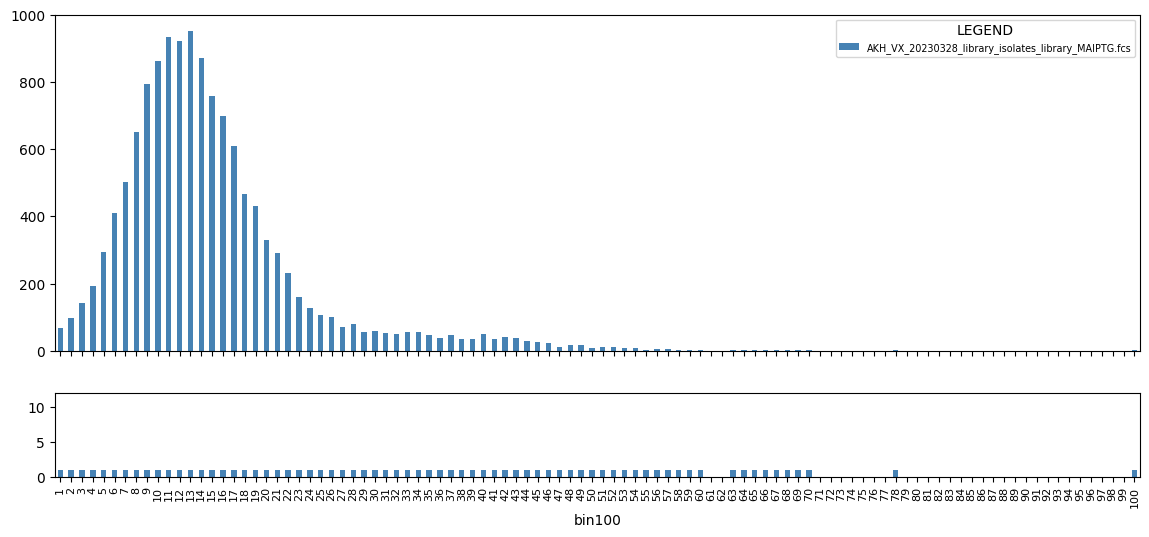

In [130]:
df = dfc_woz_lib.copy()

colname_f1 = 'mCherry-H'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=['steelblue']

ret_woz_lib = DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

## Z- Pooled (12 strains)

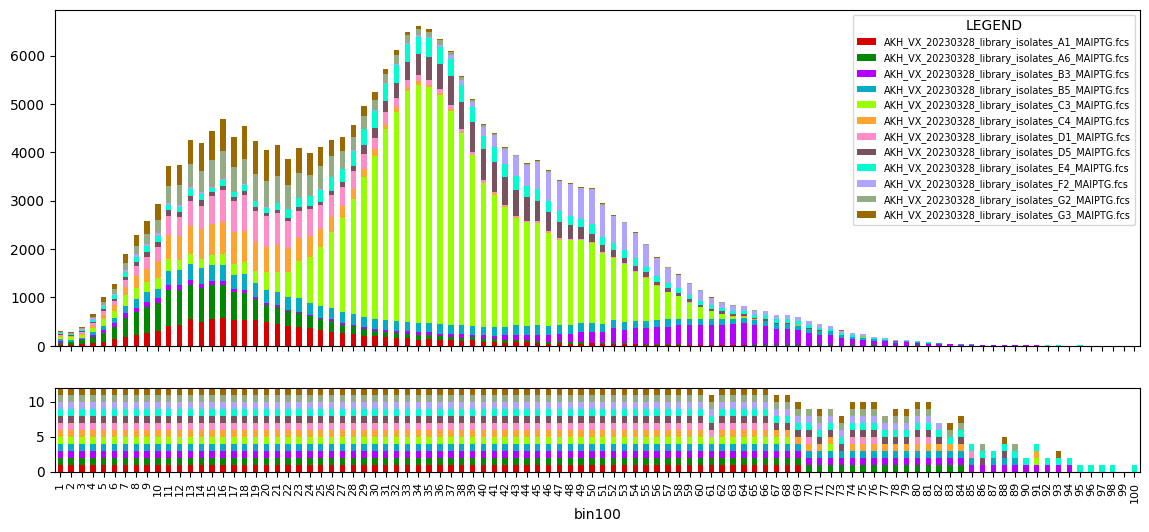

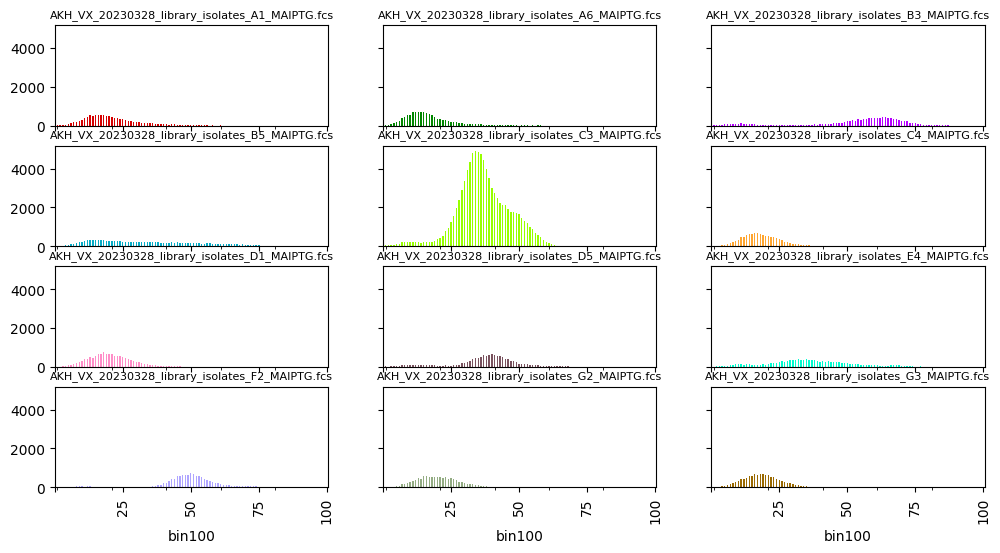

In [131]:
df = dfc_woz.copy()

colname_f1 = 'mCherry-H'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_woz_pooled = DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_woz_pooled_01 = DropletSorter.plot_histogram_strains_individual(
              df=ret_woz_pooled['df'],
              ls_sid=ls_woz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

##Z+ Lib v2 (~56 strains + artifacts)

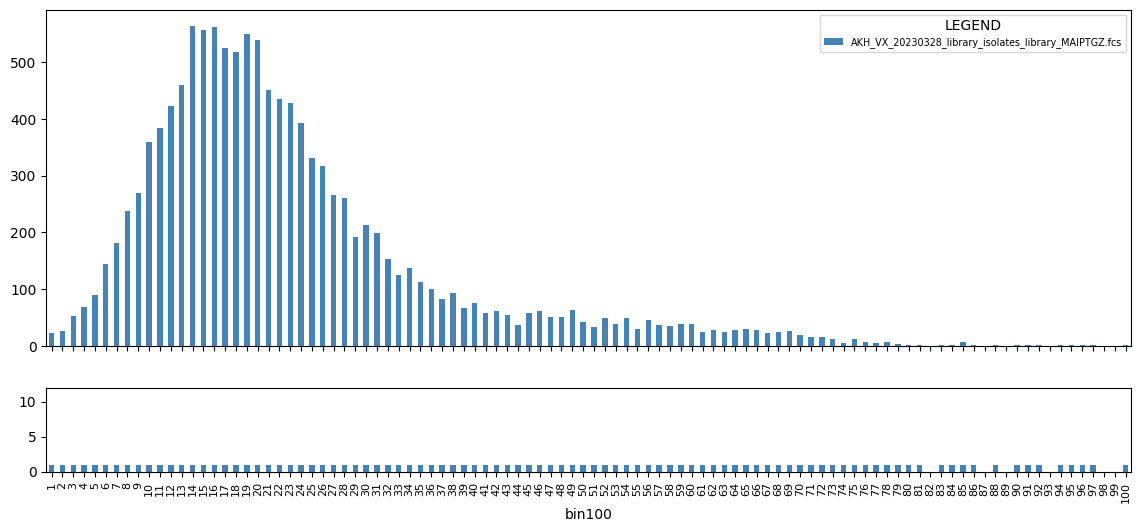

In [134]:
df = dfc_wz_lib.copy()

colname_f1 = 'mCherry-H'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=['steelblue']

ret_wz_lib = DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

## Z+ Pooled (12 strains)

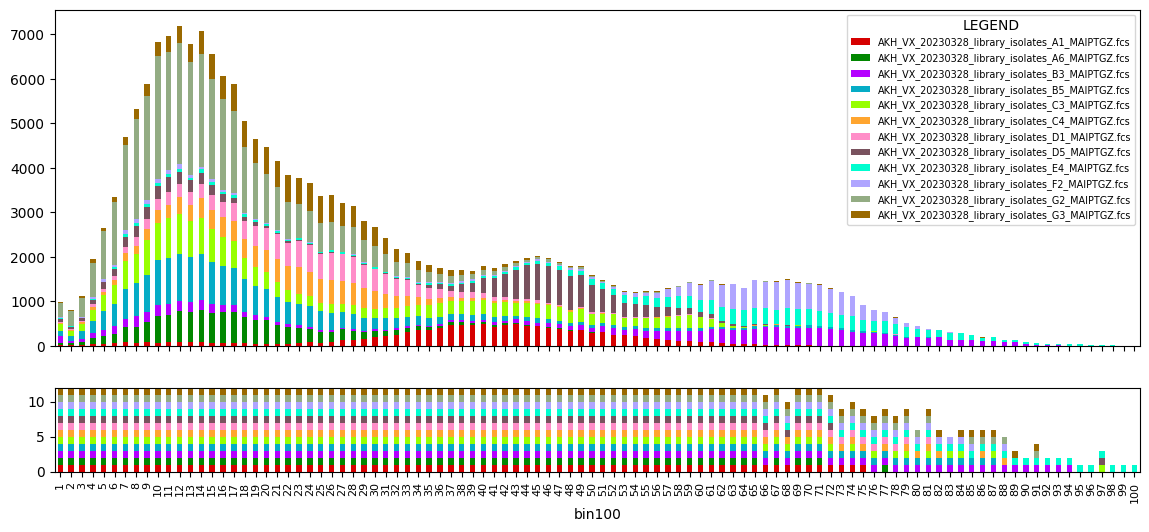

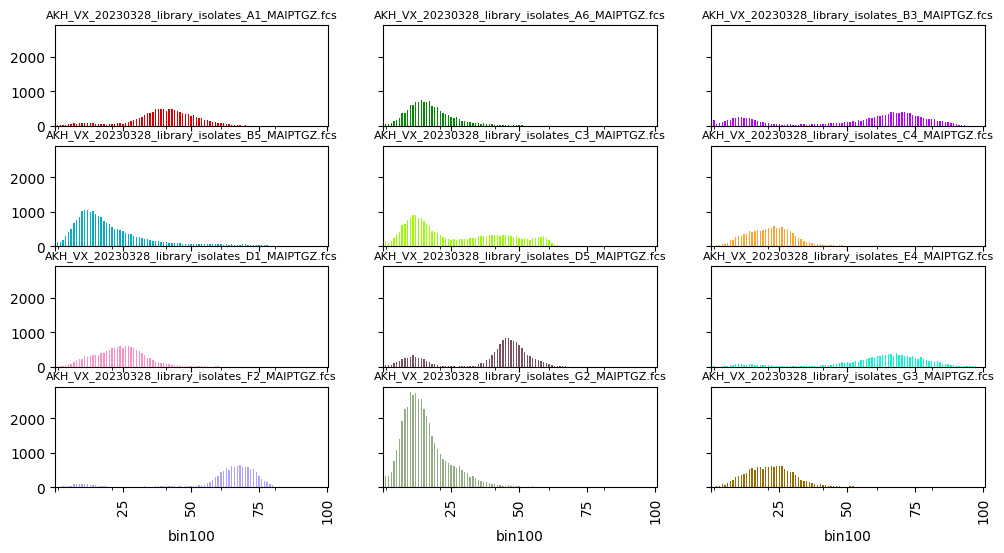

In [135]:
df = dfc_wz.copy()

colname_f1 = 'mCherry-H'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_wz_pooled = DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_wz_pooled_01 = DropletSorter.plot_histogram_strains_individual(
              df=ret_wz_pooled['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

In [147]:
cols = [
        #'index',
        'Time',
        'FSC-H', 'FSC-W', 'FSC-A',
        'SSC-H', 'SSC-H', 'SSC-A',
        'mCherry-H', 'mCherry-W', 'mCherry-A','mCherry-H_xform',
        'sid', 'P_sampling_index', 'P_sampling_sid']
dfc_wz[cols]

,Time,FSC-H,FSC-W,FSC-A,SSC-H,SSC-H,SSC-A,mCherry-H,mCherry-W,mCherry-A,mCherry-H_xform,sid,P_sampling_index,P_sampling_sid
0,0.017,62042.0,42.0,54751.0,149510.0,149510.0,138147.0,1872.0,21.0,1697.0,0.518386,AKH_VX_20230328_library_isolates_A1_MAIPTGZ.fcs,0.000005,0.060166
1,0.018,63801.0,45.0,56475.0,143861.0,143861.0,139876.0,2068.0,12.0,1165.0,0.528406,AKH_VX_20230328_library_isolates_A1_MAIPTGZ.fcs,0.000005,0.060166
2,0.019,36256.0,48.0,32185.0,160724.0,160724.0,144256.0,1617.0,16.0,1224.0,0.503584,AKH_VX_20230328_library_isolates_A1_MAIPTGZ.fcs,0.000005,0.060166
3,0.046,216199.0,89.0,292726.0,250364.0,250364.0,257544.0,854.0,0.0,929.0,0.437902,AKH_VX_20230328_library_isolates_A1_MAIPTGZ.fcs,0.000005,0.060166
4,0.058,75936.0,91.0,199931.0,189003.0,189003.0,183640.0,2465.0,26.0,2427.0,0.545996,AKH_VX_20230328_library_isolates_A1_MAIPTGZ.fcs,0.000005,0.060166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204886,42.248,79250.0,62.0,157797.0,29149.0,29149.0,24977.0,18.0,0.0,-42.0,0.131213,AKH_VX_20230328_library_isolates_G3_MAIPTGZ.fcs,0.000009,0.134880
204887,42.253,292537.0,93.0,374162.0,249579.0,249579.0,243238.0,548.0,0.0,466.0,0.390887,AKH_VX_20230328_library_isolates_G3_MAIPTGZ.fcs,0.000009,0.134880
204888,42.257,78650.0,20.0,-14612.0,168335.0,168335.0,150843.0,100.0,0.0,44.0,0.213181,AKH_VX_20230328_library_isolates_G3_MAIPTGZ.fcs,0.000009,0.134880
204889,42.264,153474.0,77.0,228124.0,189735.0,189735.0,186474.0,156.0,0.0,118.0,0.255117,AKH_VX_20230328_library_isolates_G3_MAIPTGZ.fcs,0.000009,0.134880


In [77]:
ret_wz_pooled_01['dfstrain']

pns,index,Time,FSC-A,SSC-A,SYTOX Green-A,mCherry-A,FSC-H,SSC-H,SYTOX Green-H,mCherry-H,FSC-W,SSC-W,SYTOX Green-W,mCherry-W,sid,mCherry-A_xform,bin,bin100
190554,0,0.052,173787.0,35874.0,58.0,-78.0,104621.0,37684.0,158.0,76.0,68.0,64.0,0.0,0.0,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,0.028750,"(0.0169, 0.0326]",32
190555,1,0.079,617406.0,378761.0,86296.0,337.0,207056.0,350459.0,78292.0,444.0,107.0,107.0,96.0,0.0,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,0.338049,"(0.33, 0.346]",52
190556,2,0.099,143580.0,208488.0,30813.0,457.0,69970.0,206234.0,30174.0,350.0,93.0,93.0,79.0,0.0,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,0.371291,"(0.362, 0.377]",54
190557,3,0.164,1048575.0,296741.0,73552.0,334.0,288707.0,286909.0,68904.0,335.0,100.0,97.0,91.0,0.0,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,0.337068,"(0.33, 0.346]",52
190558,4,0.251,249301.0,213920.0,50704.0,353.0,112779.0,216250.0,48070.0,435.0,94.0,92.0,83.0,0.0,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,0.343133,"(0.33, 0.346]",52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204886,14332,42.248,157797.0,24977.0,106.0,-42.0,79250.0,29149.0,83.0,18.0,62.0,57.0,0.0,0.0,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,0.064885,"(0.0639, 0.0796]",35
204887,14333,42.253,374162.0,243238.0,43471.0,466.0,292537.0,249579.0,41735.0,548.0,93.0,90.0,83.0,0.0,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,0.373405,"(0.362, 0.377]",54
204888,14334,42.257,-14612.0,150843.0,26822.0,44.0,78650.0,168335.0,27325.0,100.0,20.0,68.0,64.0,0.0,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,0.159455,"(0.158, 0.174]",41
204889,14335,42.264,228124.0,186474.0,30099.0,118.0,153474.0,189735.0,29591.0,156.0,77.0,90.0,77.0,0.0,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,0.227900,"(0.221, 0.236]",45


# Simulated Analysis - Cells

## FACS only

### (1) equal abundance sampling

In [136]:
abundances_equal = [1/len(ls_wz)]*len(ls_wz)
strain2P = dict(zip(ls_wz, abundances_equal))

tmp_ret = FlowData.assign_sampling_probability(dfc_wz, strain2P=strain2P) #, strain2P=strain2P)
# assign random abundance to strains in the collections
dfc_wz = tmp_ret['df']
print(pd.Series(tmp_ret['strain2P']).sort_index())

AKH_VX_20230328_library_isolates_A1_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_A6_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_B3_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_B5_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_C3_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_C4_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_D1_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_D5_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_E4_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_F2_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_G2_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_G3_MAIPTGZ.fcs    0.083333
dtype: float64


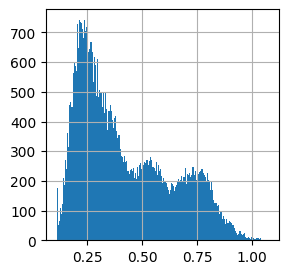

In [137]:
df = dfc_wz
colname_f1 = 'mCherry-H'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

ret_facs_01 = Flowcytometry.analyze(
    df=df,
    n_rounds=50000,
    colname_f1=colname_f1_xform,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    replace=False,
    bins=200,
    figsize=(3,3),
    )

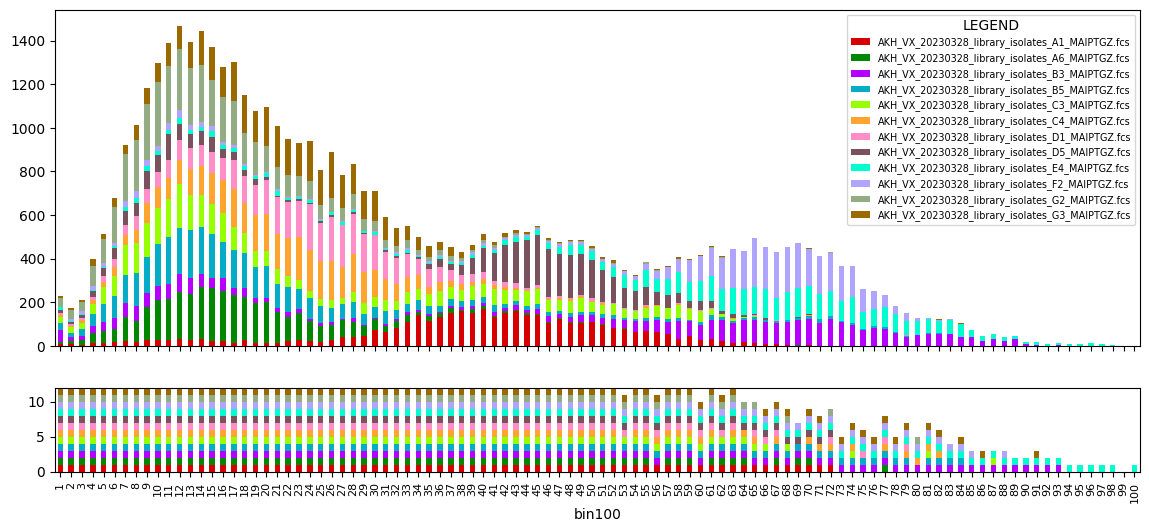

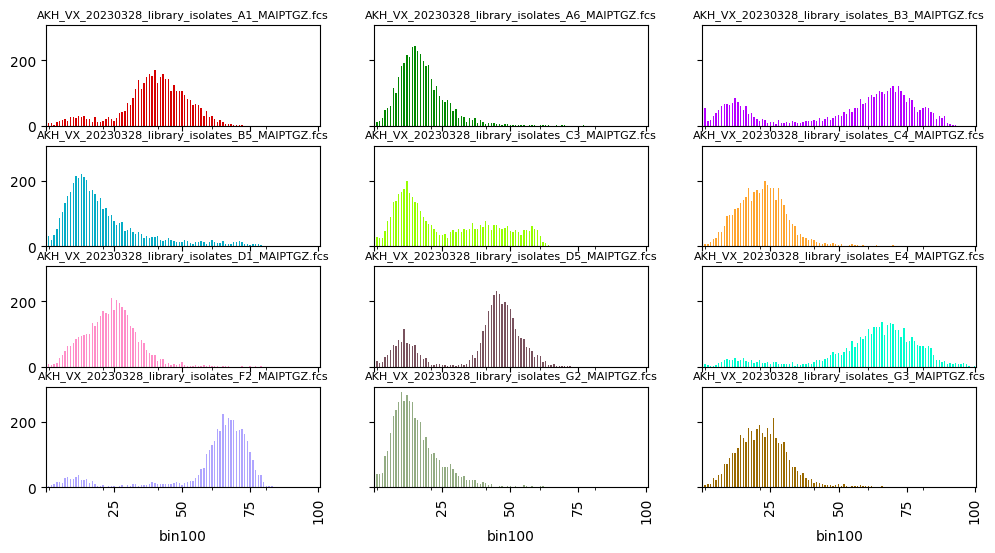

In [138]:
df = ret_facs_01['df']

colname_f1 = 'mCherry-H'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret = DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret1 = DropletSorter.plot_histogram_strains_individual(
              df=ret['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

###(2) proportional abundance sampling
strains are sampled at proportional abundance to the full dataset

In [139]:
# Generate proportional abundance and assign to df
tmp_ret = FlowData.assign_sampling_probability(dfc_wz, strain2P=None) #, strain2P=strain2P)
dfc_wz = tmp_ret['df']
print(pd.Series(tmp_ret['strain2P']))

AKH_VX_20230328_library_isolates_A1_MAIPTGZ.fcs    0.058587
AKH_VX_20230328_library_isolates_A6_MAIPTGZ.fcs    0.060906
AKH_VX_20230328_library_isolates_B3_MAIPTGZ.fcs    0.069998
AKH_VX_20230328_library_isolates_B5_MAIPTGZ.fcs    0.107345
AKH_VX_20230328_library_isolates_C3_MAIPTGZ.fcs    0.106003
AKH_VX_20230328_library_isolates_C4_MAIPTGZ.fcs    0.060827
AKH_VX_20230328_library_isolates_D1_MAIPTGZ.fcs    0.065645
AKH_VX_20230328_library_isolates_D5_MAIPTGZ.fcs    0.071638
AKH_VX_20230328_library_isolates_E4_MAIPTGZ.fcs    0.056879
AKH_VX_20230328_library_isolates_F2_MAIPTGZ.fcs    0.058748
AKH_VX_20230328_library_isolates_G2_MAIPTGZ.fcs    0.213450
AKH_VX_20230328_library_isolates_G3_MAIPTGZ.fcs    0.069974
dtype: float64


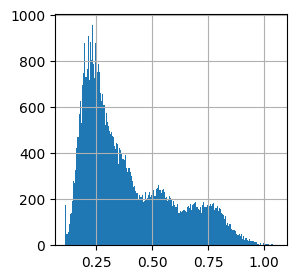

In [140]:
df = dfc_wz.copy()
colname_f1 = 'mCherry-H'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])


ret_facs_02 = Flowcytometry.analyze(
    df=df,
    n_rounds=50000,
    colname_f1=colname_f1_xform,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    replace=False,
    bins=200,
    figsize=(3,3),
    )

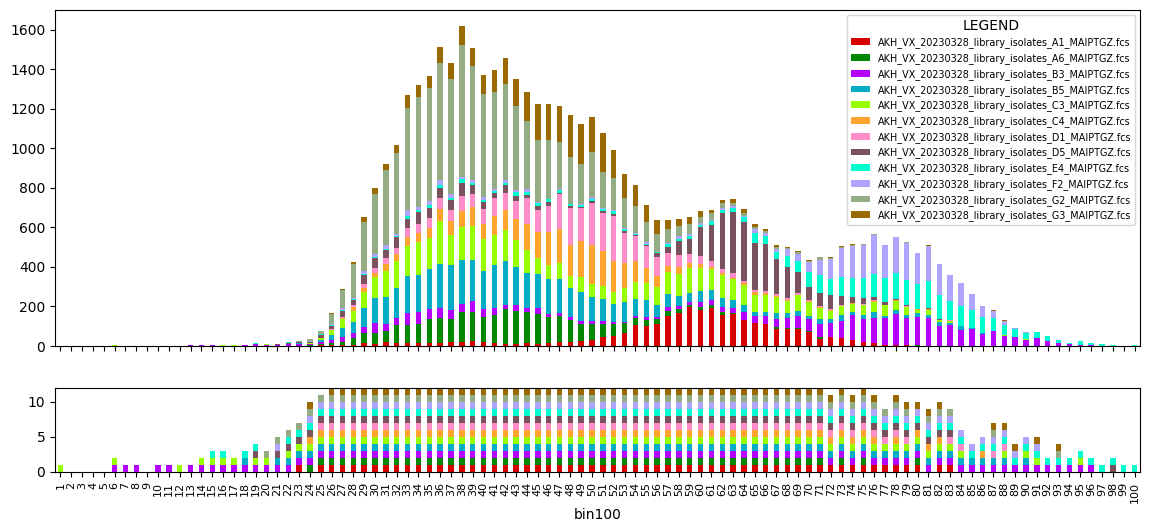

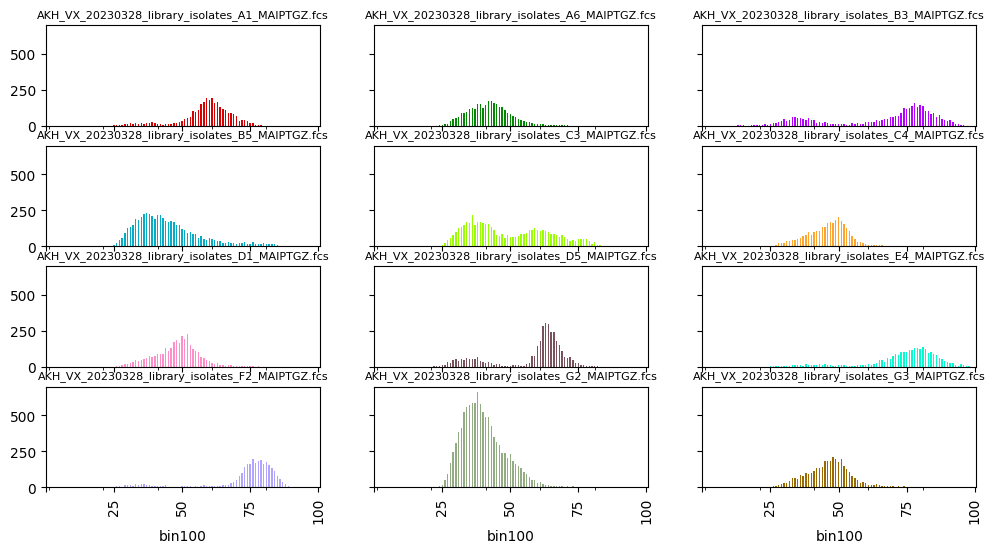

In [141]:
df = ret_facs_02['df']

colname_f1 = 'mCherry-A'
colname_f1_xform = '{}_xform'.format(colname_f1)

bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret = DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret1 = DropletSorter.plot_histogram_strains_individual(
              df=ret['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

###(3) random abundance sampling
from the population

In [142]:
# Generate random abundance and assign to df
#abundances_random = fld.generate_abuduance(a=3, scale=10, size=len(ls_wz))
abundances_random = [0.06016566, 0.02113162, 0.04187348, 0.26106276, 0.10405436, 0.04489549,
                     0.04325233, 0.03035451, 0.06089064, 0.11688058, 0.08055852, 0.13488005]
strain2P_random = dict(zip(ls_wz, abundances_random))

In [143]:
tmp_ret = FlowData.assign_sampling_probability(dfc_wz, strain2P=strain2P_random) #, strain2P=strain2P)
# assign random abundance to strains in the collections
dfc_wz = tmp_ret['df']
print(pd.Series(tmp_ret['strain2P']).sort_index())

AKH_VX_20230328_library_isolates_A1_MAIPTGZ.fcs    0.060166
AKH_VX_20230328_library_isolates_A6_MAIPTGZ.fcs    0.021132
AKH_VX_20230328_library_isolates_B3_MAIPTGZ.fcs    0.041873
AKH_VX_20230328_library_isolates_B5_MAIPTGZ.fcs    0.261063
AKH_VX_20230328_library_isolates_C3_MAIPTGZ.fcs    0.104054
AKH_VX_20230328_library_isolates_C4_MAIPTGZ.fcs    0.044895
AKH_VX_20230328_library_isolates_D1_MAIPTGZ.fcs    0.043252
AKH_VX_20230328_library_isolates_D5_MAIPTGZ.fcs    0.030355
AKH_VX_20230328_library_isolates_E4_MAIPTGZ.fcs    0.060891
AKH_VX_20230328_library_isolates_F2_MAIPTGZ.fcs    0.116881
AKH_VX_20230328_library_isolates_G2_MAIPTGZ.fcs    0.080559
AKH_VX_20230328_library_isolates_G3_MAIPTGZ.fcs    0.134880
dtype: float64


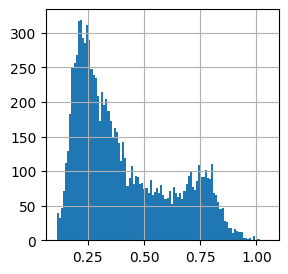

In [144]:
df = dfc_wz
colname_f1 = 'mCherry-H'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

ret_facs_03 = Flowcytometry.analyze(
    df=df,
    n_rounds=10000,
    colname_f1=colname_f1_xform,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    replace=False,
    bins=100,
    figsize=(3,3),
    )

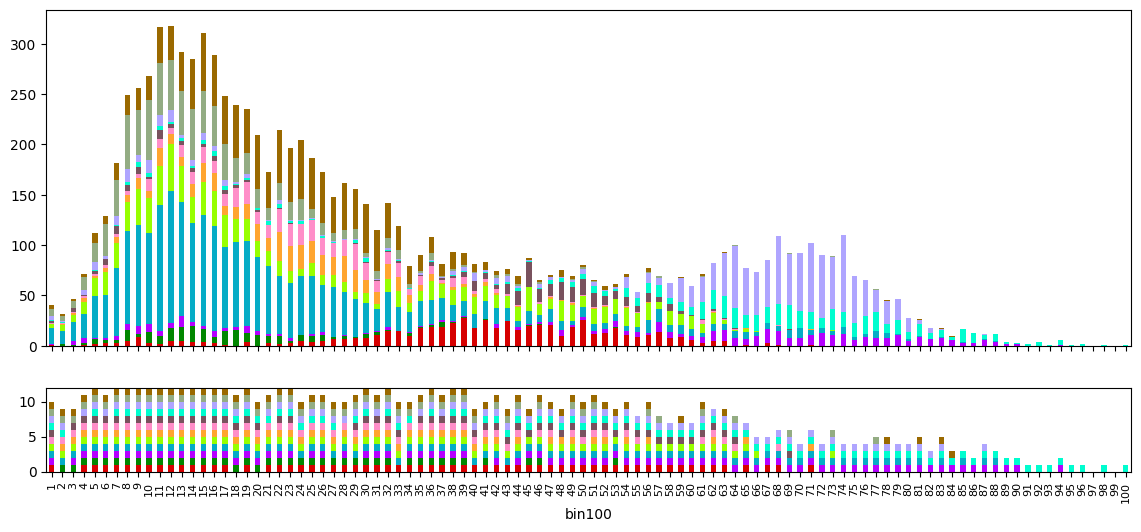

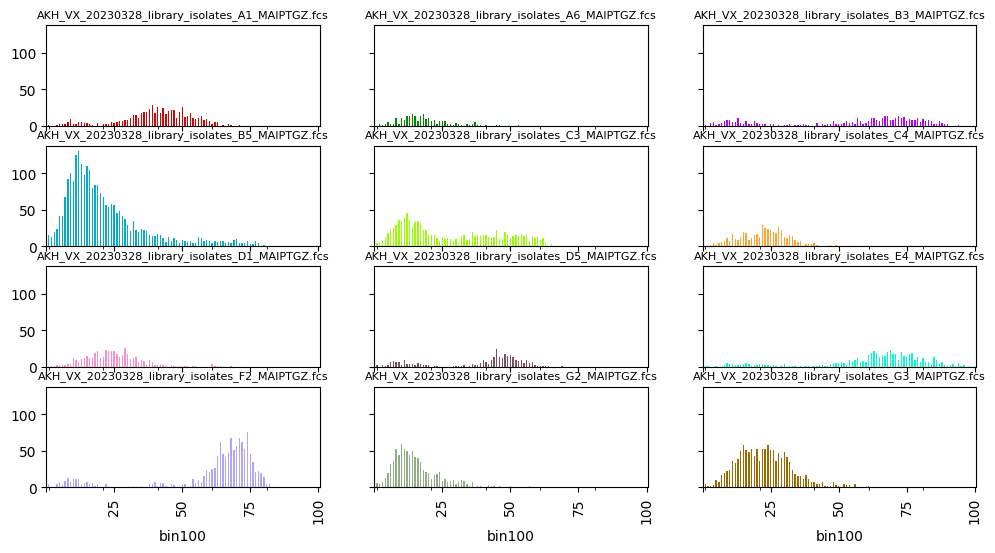

In [145]:
df = ret_facs_03['df']

colname_f1 = 'mCherry-H'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret = DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    #ylim=(0,50),
    font_size='x-small',
    remove_legend=True,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret1 = DropletSorter.plot_histogram_strains_individual(
              df=ret['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

### Sanity Check

In [30]:
# Sanity Check
# the sum of P_sid shall equal to 1
check_P_sampling_sid = FlowData.assign_sampling_probability(
    dfc_wz, strain2P=strain2P)['df'][['sid', 'P_sampling_sid']]. \
    drop_duplicates(keep='first')['P_sampling_sid'].sum()
print(check_P_sampling_sid)
check_P_sampling_index = FlowData.assign_sampling_probability(dfc_wz)['df']['P_sampling_index'].sum()
print(check_P_sampling_index)

1.0
1.0000000000000004


## Droplet Culture + Droplet FACS

In [31]:
ret_dsorter = {}

### (1) equal abundance

In [98]:
ret_dsorter['abundance_equal'] = {}

In [99]:
abundances_equal = [1/len(ls_wz)]*len(ls_wz)
strain2P = dict(zip(ls_wz, abundances_equal))

tmp_ret = FlowData.assign_sampling_probability(dfc_wz, strain2P=strain2P) #, strain2P=strain2P)
# assign random abundance to strains in the collections
dfc_wz = tmp_ret['df']
print(pd.Series(tmp_ret['strain2P']).sort_index())

AKH_VX_20230328_library_isolates_A1_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_A6_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_B3_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_B5_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_C3_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_C4_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_D1_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_D5_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_E4_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_F2_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_G2_MAIPTGZ.fcs    0.083333
AKH_VX_20230328_library_isolates_G3_MAIPTGZ.fcs    0.083333
dtype: float64


#### control
<p>droplet size = 40 um
<p>num cells encapsulated = 1
<p>num events = 10000

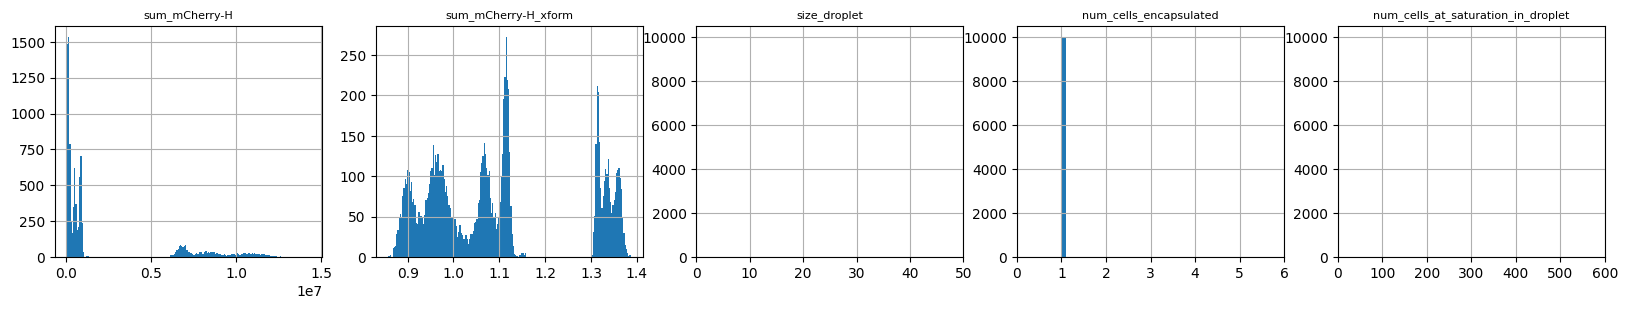

In [100]:
df = dfc_wz.copy()
colname_f1='mCherry-H'
colname_f1_xform= '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

ret_dsorter['abundance_equal']['control'] = DropletSorter.culture_sort(
    df=df,
    n_rounds=10000,
    colname_f1=colname_f1,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    size_droplet=40,
    size_type='diameter',
    func_droplet_size=np.random.normal,
    scale_droplet_size=0,
    size_left_curve_only=False,
    bins=200,
    num_cells_encapsulated=1,
    func_cells_encapsulated_per_droplet=None, #np.random.poisson,
    cell_encapsulation_rate=0.1,
    discard_empty_droplets=True,
    rng=np.random.default_rng(),
    figsize=None)

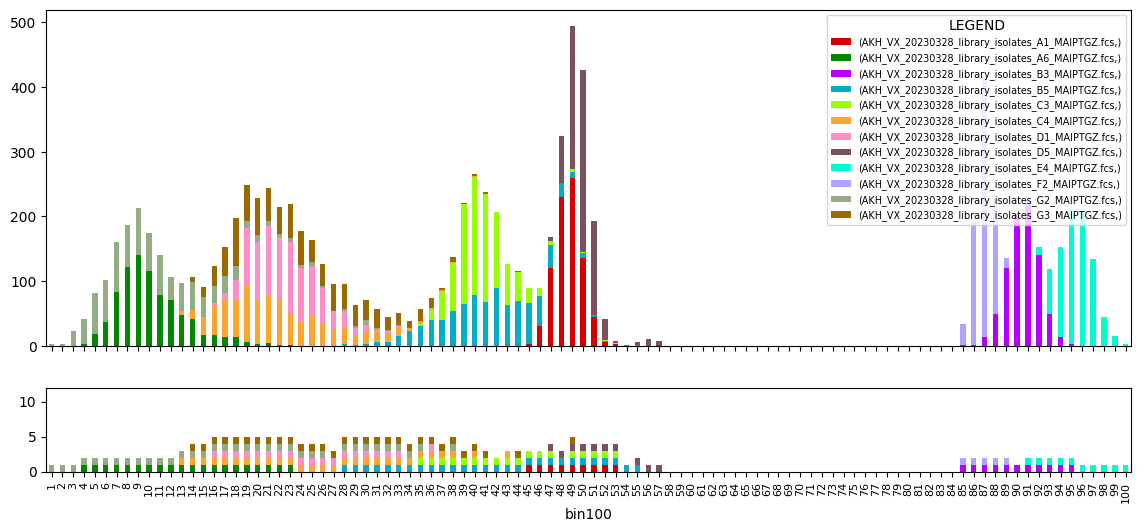

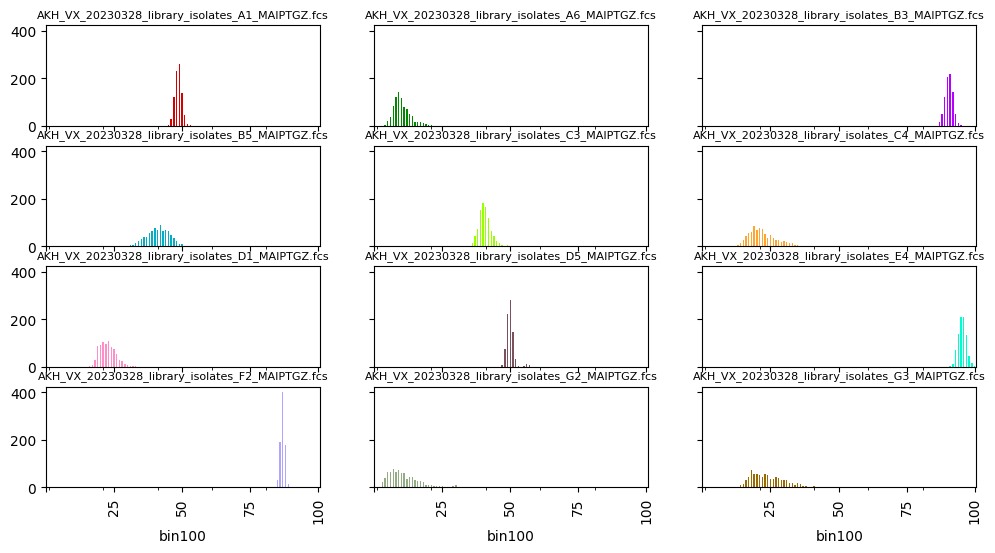

In [101]:
df = ret_dsorter['abundance_equal']['control']['df'].copy()

colname_f1 = 'sum_mCherry-H'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_equal']['control_01'] = DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_equal']['control_02'] = DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_equal']['control_01']['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

#### varying mCherry signal measurement

In [36]:
ret_dsorter['abundance_equal']['v_measurement'] = {}

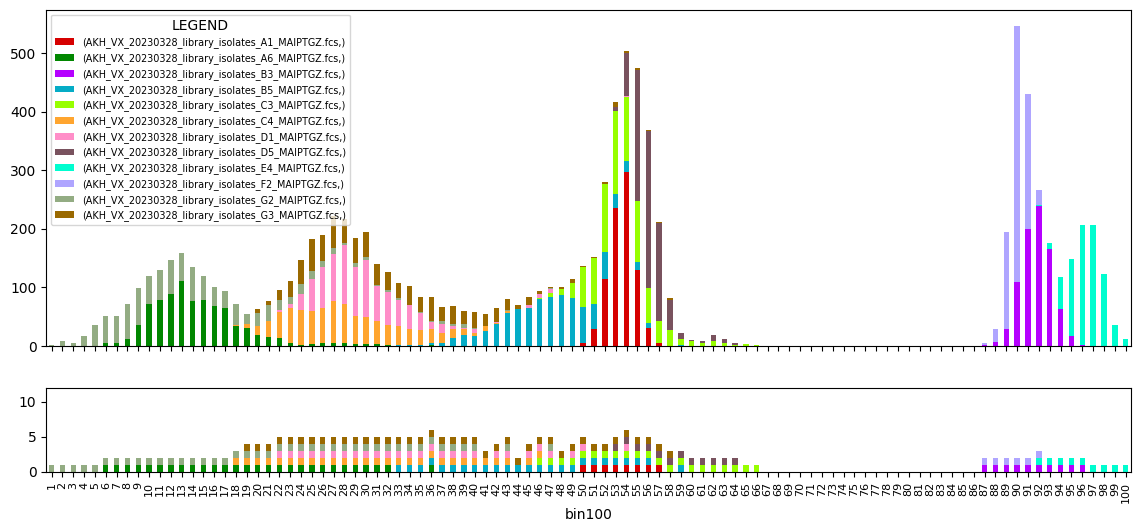

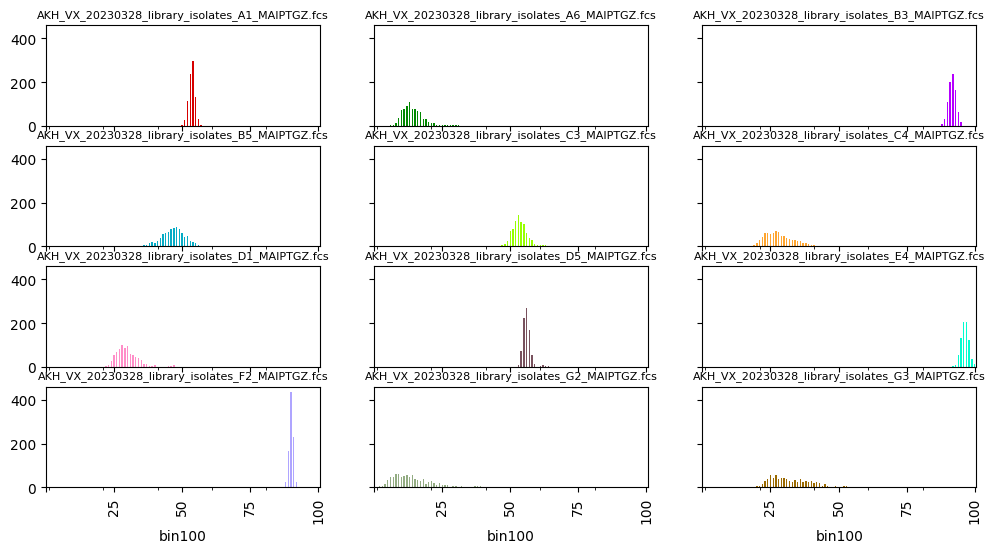

In [37]:
# In the control, mCherry-A signals from all cells are summed

# sum mCherry-A in droplet / num cells in droplet
df = ret_dsorter['abundance_equal']['control']['df'].copy()


colname_f1 = 'sum_mCherry-A'
df['AvgCell_mCherry-A'] = df[colname_f1] / df['num_cells_at_saturation_in_droplet']

colname_f1 = 'AvgCell_mCherry-A'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_equal']['v_measurement'][colname_f1]= DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_equal']['v_measurement'][colname_f1 + '_01'] = DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_equal']['v_measurement'][colname_f1]['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

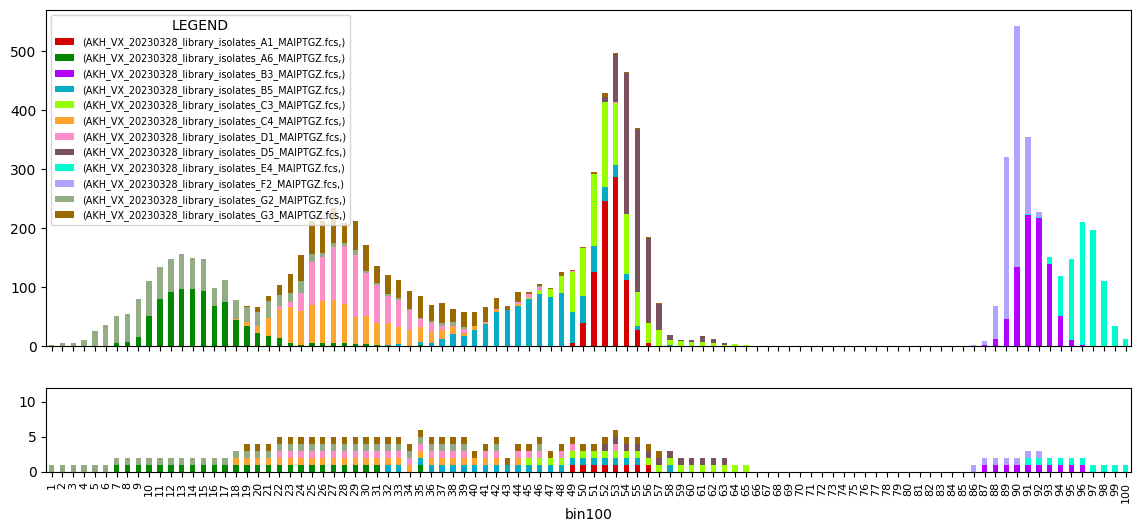

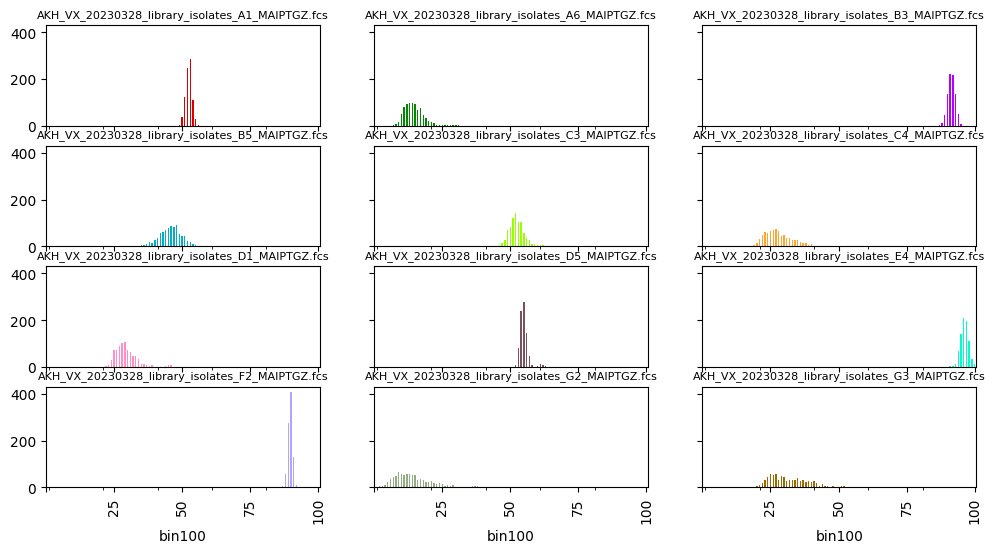

In [38]:
# In the control, mCherry-A signals from all cells are summed

# sum mCherry-A in droplet / ratio of largest slice to volume of the droplet, assuming slicing thickness of one
# (r**2*math.pi) / (r**3*math.pi*4/3) = 3/4/r = 3/4/r
df = ret_dsorter['abundance_equal']['control']['df'].copy()


colname_f1 = 'sum_mCherry-A'
df['CircularSlice_mCherry-A'] = df[colname_f1] * df['size_droplet'].apply(lambda x: 3/4/(x/2))

colname_f1 = 'CircularSlice_mCherry-A'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_equal']['v_measurement'][colname_f1] = DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_equal']['v_measurement'][colname_f1 + '_01'] = DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_equal']['v_measurement'][colname_f1]['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

#### varying cell size

In [39]:
ret_dsorter['abundance_equal']['v_dropletsize'] = {}

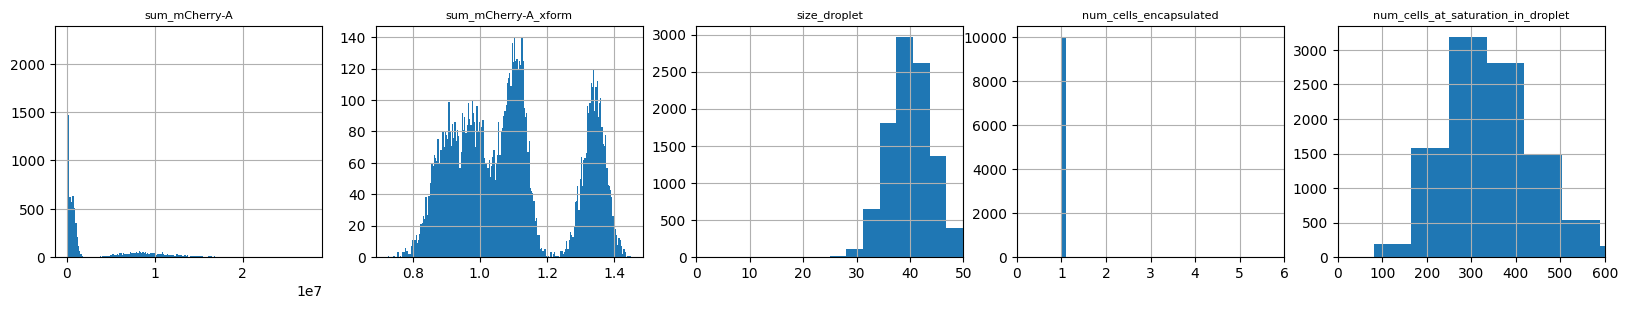

In [40]:
df = dfc_wz.copy()

colname_f1='mCherry-A'
colname_f1_xform= '{}_xform'.format(colname_f1)

ret_dsorter['abundance_equal']['v_dropletsize']['scale_dot1'] = DropletSorter.culture_sort(
    df=df,
    n_rounds=10000,
    colname_f1=colname_f1,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    size_droplet=40,
    size_type='diameter',
    func_droplet_size=np.random.normal,
    scale_droplet_size=0.1,
    size_left_curve_only=False,
    bins=200,
    num_cells_encapsulated=1,
    func_cells_encapsulated_per_droplet=None, #np.random.poisson,
    cell_encapsulation_rate=0.1,
    discard_empty_droplets=True,
    rng=np.random.default_rng(),
    figsize=None)

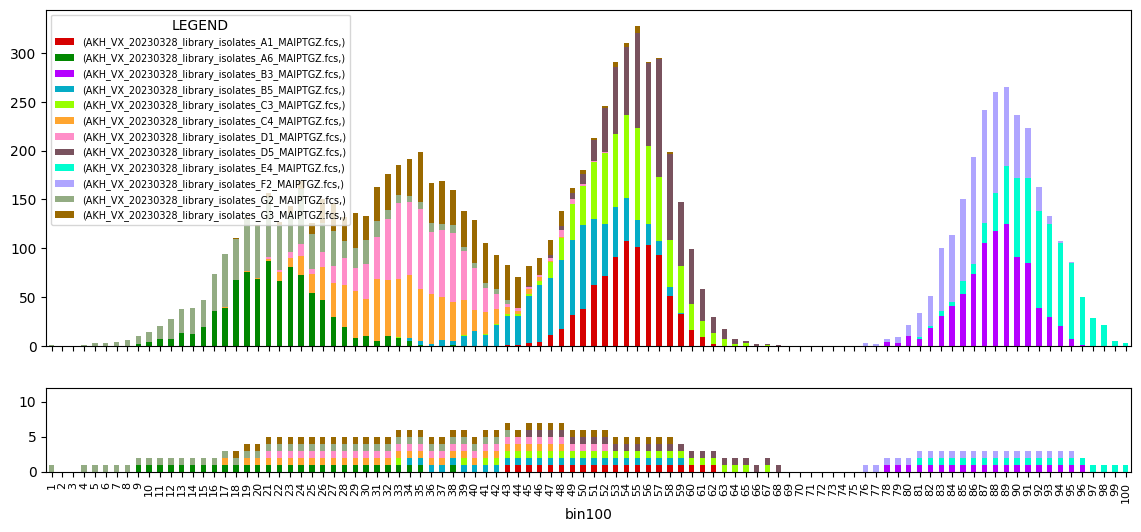

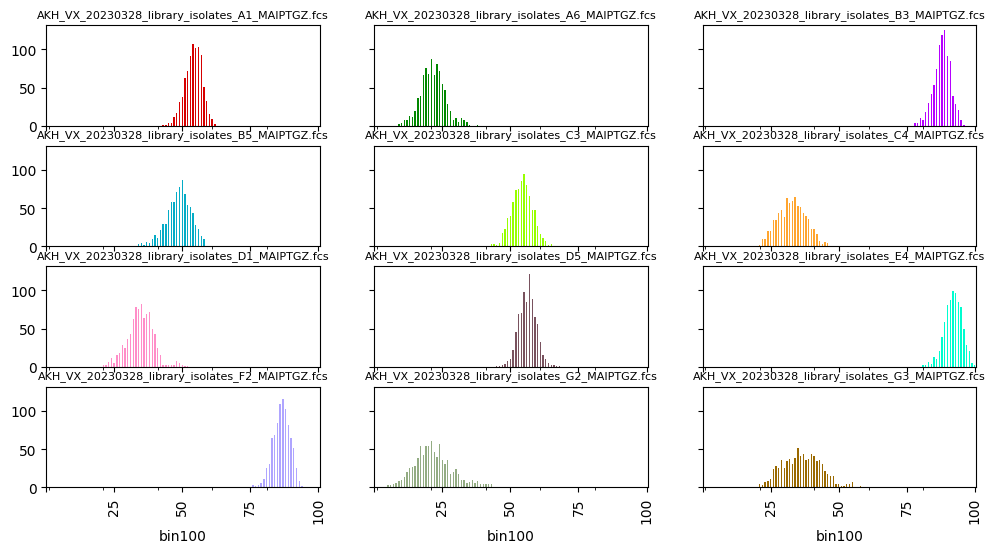

In [41]:
# droplet size scale =0.1
df = ret_dsorter['abundance_equal']['v_dropletsize']['scale_dot1']['df'].copy()

colname_f1 = 'sum_mCherry-A'

df['AvgCell_mCherry-A'] = df[colname_f1] / df['num_cells_at_saturation_in_droplet']
df['CircularSlice_mCherry-A'] = df[colname_f1] * df['size_droplet'].apply(lambda x: 3/4/(x/2))

colname_f1 = 'CircularSlice_mCherry-A'
#colname_f1 = 'AvgCell_mCherry-A'

colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_equal']['v_dropletsize']['scale_dot1_01']= DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_equal']['v_dropletsize']['scale_dot1_02']= DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_equal']['v_dropletsize']['scale_dot1_01']['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

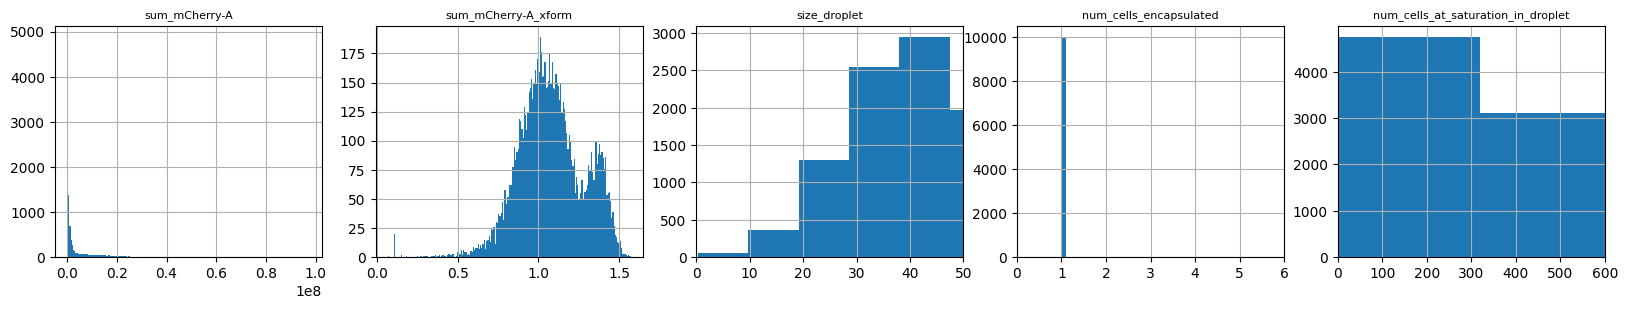

In [42]:
df = dfc_wz.copy()

colname_f1='mCherry-A'
colname_f1_xform= '{}_xform'.format(colname_f1)

ret_dsorter['abundance_equal']['v_dropletsize']['scale_dot3'] = DropletSorter.culture_sort(
    df=df,
    n_rounds=10000,
    colname_f1=colname_f1,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    size_droplet=40,
    size_type='diameter',
    func_droplet_size=np.random.normal,
    scale_droplet_size=0.3,
    size_left_curve_only=False,
    bins=200,
    num_cells_encapsulated=1,
    func_cells_encapsulated_per_droplet=None, #np.random.poisson,
    cell_encapsulation_rate=0.1,
    discard_empty_droplets=True,
    rng=np.random.default_rng(),
    figsize=None)

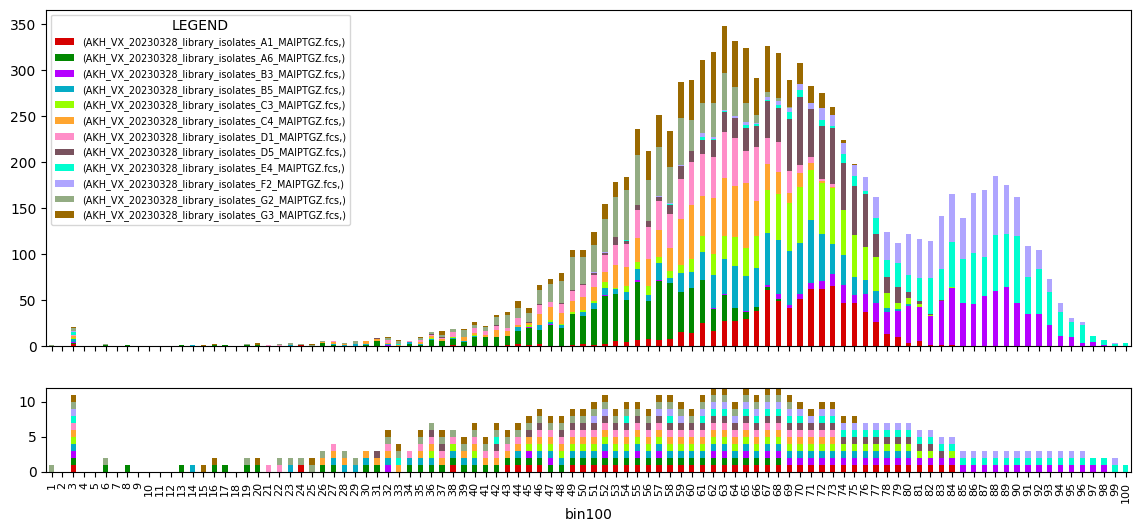

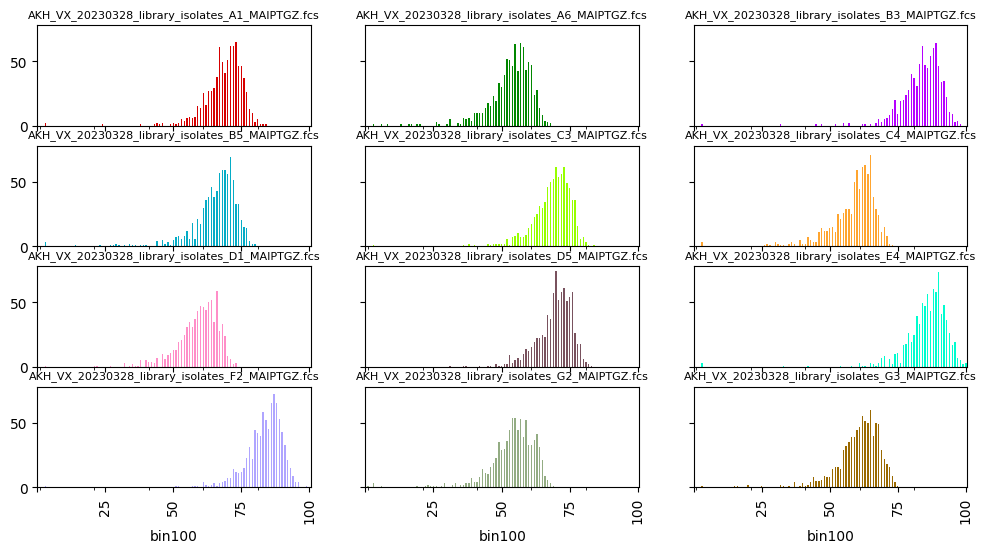

In [43]:
# droplet size scale =0.1
df = ret_dsorter['abundance_equal']['v_dropletsize']['scale_dot3']['df'].copy()

colname_f1 = 'sum_mCherry-A'

df['AvgCell_mCherry-A'] = df[colname_f1] / df['num_cells_at_saturation_in_droplet']
df['CircularSlice_mCherry-A'] = df[colname_f1] * df['size_droplet'].apply(lambda x: 3/4/(x/2))

#colname_f1 = 'CircularSlice_mCherry-A'
#colname_f1 = 'AvgCell_mCherry-A'

colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_equal']['v_dropletsize']['scale_dot3_01']= DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_equal']['v_dropletsize']['scale_dot3_02']= DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_equal']['v_dropletsize']['scale_dot3_01']['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

# increasing variability in droplet size increases the right skewness of fluorecense measurement.

#### varying num cells encapsualted

In [44]:
ret_dsorter['abundance_equal']['v_num_cells_encapsulated'] = {}

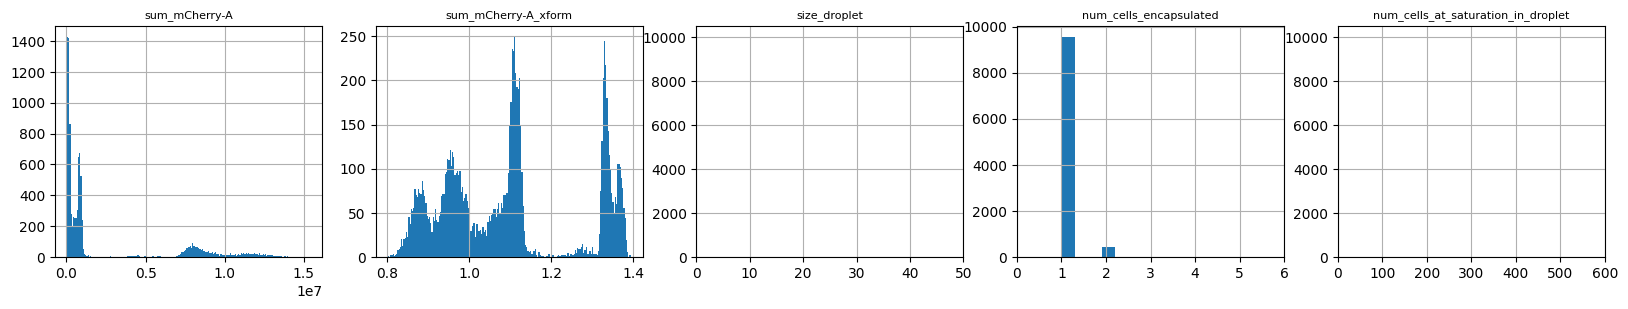

In [45]:
df = dfc_wz.copy()
colname_f1='mCherry-A'
colname_f1_xform= '{}_xform'.format(colname_f1)

ret_dsorter['abundance_equal']['v_num_cells_encapsulated']['rate_dot1'] = DropletSorter.culture_sort(
    df=df,
    n_rounds=10000,
    colname_f1=colname_f1,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    size_droplet=40,
    size_type='diameter',
    func_droplet_size=np.random.normal,
    scale_droplet_size=0,
    size_left_curve_only=False,
    bins=200,
    num_cells_encapsulated=1,
    func_cells_encapsulated_per_droplet=np.random.poisson,
    cell_encapsulation_rate=0.1,
    discard_empty_droplets=True,
    rng=np.random.default_rng(),
    figsize=None)

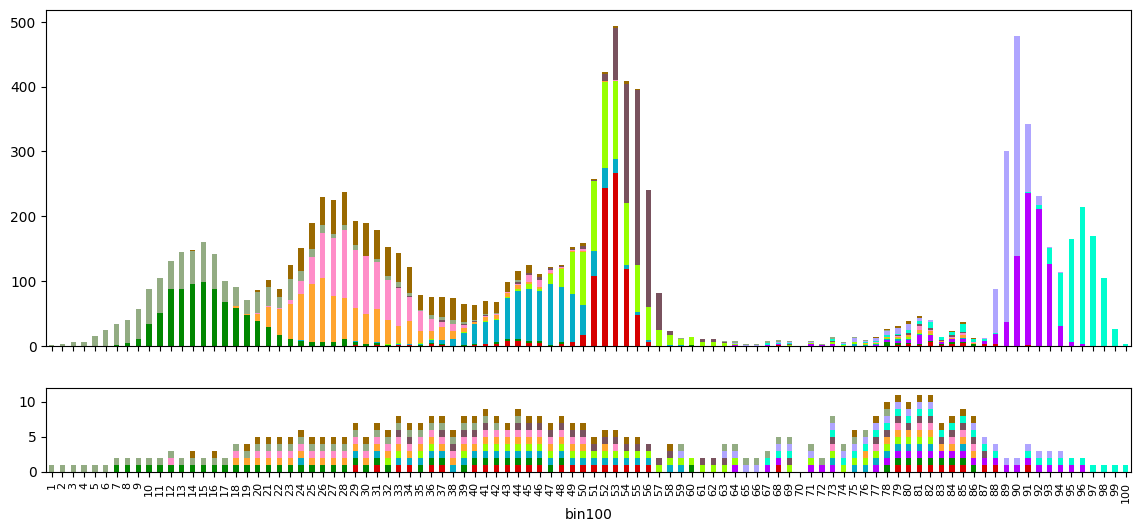

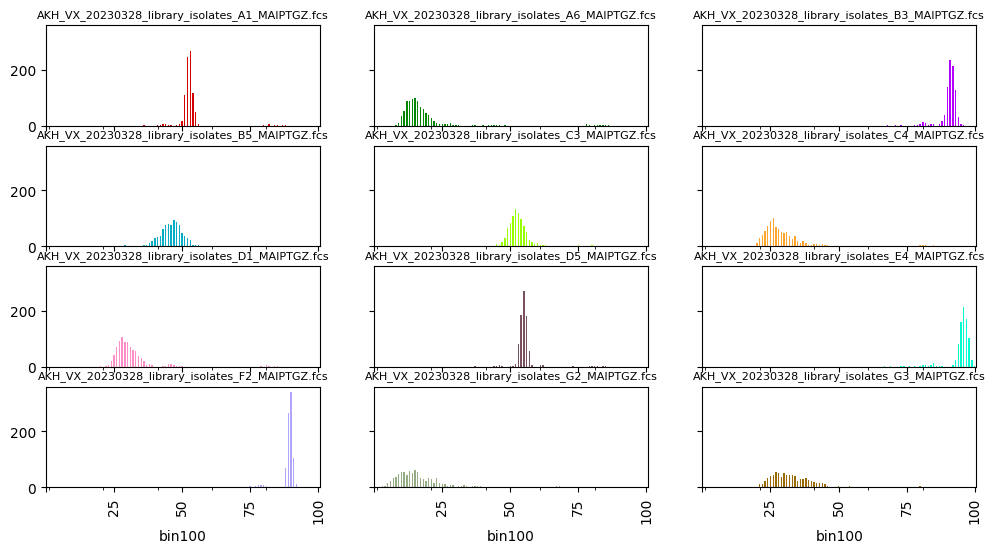

In [46]:
df = ret_dsorter['abundance_equal']['v_num_cells_encapsulated']['rate_dot1']['df'].copy()
columns = df.columns

colname_f1 = 'sum_mCherry-A'

df['AvgCell_mCherry-A'] = df[colname_f1] / df['num_cells_at_saturation_in_droplet']
df['CircularSlice_mCherry-A'] = df[colname_f1] * df['size_droplet'].apply(lambda x: 3/4/(x/2))

colname_f1 = 'CircularSlice_mCherry-A'
#colname_f1 = 'AvgCell_mCherry-A'

colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

# demultiplex strains for multi-cell encapsulation
df.rename(columns={'sid':'sid_combo'}, inplace=True)
columns = df.columns
df_sid_demultiplexed = df['sid_combo'].apply(';'.join).str.split(';', expand=True)
df[df_sid_demultiplexed.columns] = df_sid_demultiplexed
dfm = df.melt(id_vars=columns, var_name='id_in_droplet', value_name='sid').dropna(subset=['sid'])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_equal']['v_num_cells_encapsulated']['rate_dot1_01']= DropletSorter.plot_histogram_highlighting_strains(
    df=dfm,
    colname_f1=colname_f1_xform,
    colname_strain='sid', #'sid
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=True,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_equal']['v_num_cells_encapsulated']['rate_dot1_02']= DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_equal']['v_num_cells_encapsulated']['rate_dot1_01']['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              colname_strain='sid',
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

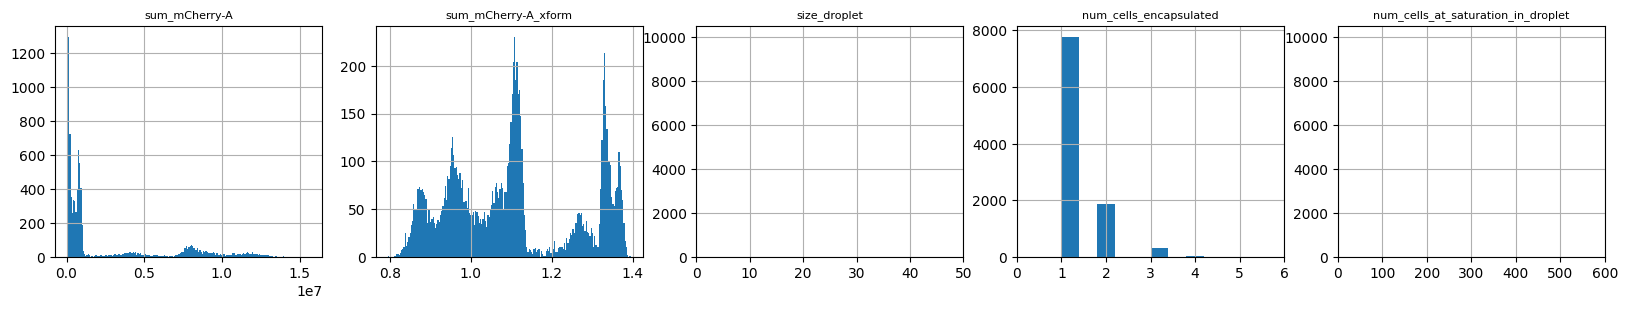

In [47]:
df = dfc_wz.copy()
colname_f1='mCherry-A'
colname_f1_xform= '{}_xform'.format(colname_f1)

ret_dsorter['abundance_equal']['v_num_cells_encapsulated']['rate_dot5'] = DropletSorter.culture_sort(
    df=df,
    n_rounds=10000,
    colname_f1=colname_f1,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    size_droplet=40,
    size_type='diameter',
    func_droplet_size=np.random.normal,
    scale_droplet_size=0,
    size_left_curve_only=False,
    bins=200,
    num_cells_encapsulated=1,
    func_cells_encapsulated_per_droplet=np.random.poisson,
    cell_encapsulation_rate=0.5,
    discard_empty_droplets=True,
    rng=np.random.default_rng(),
    figsize=None)

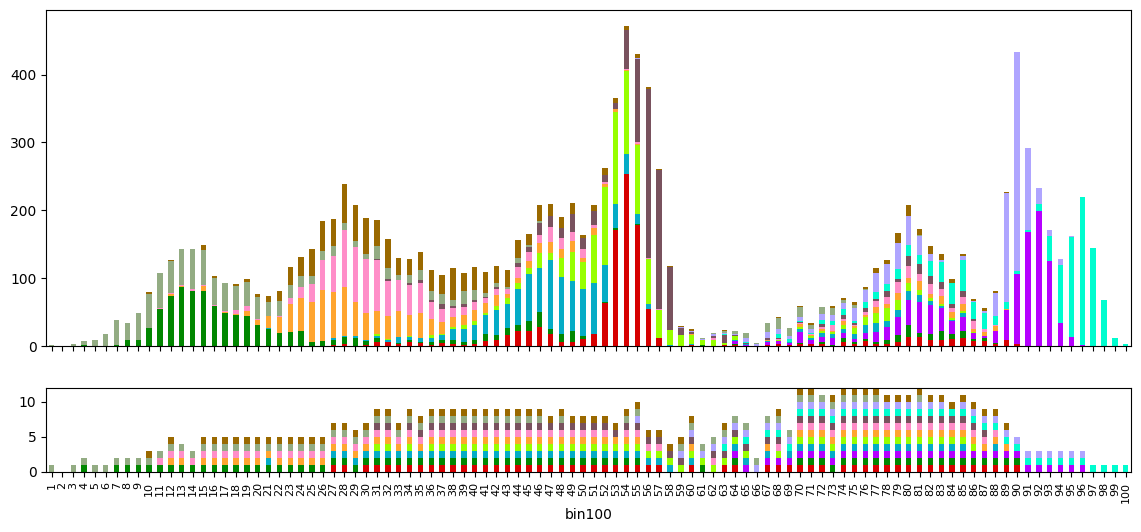

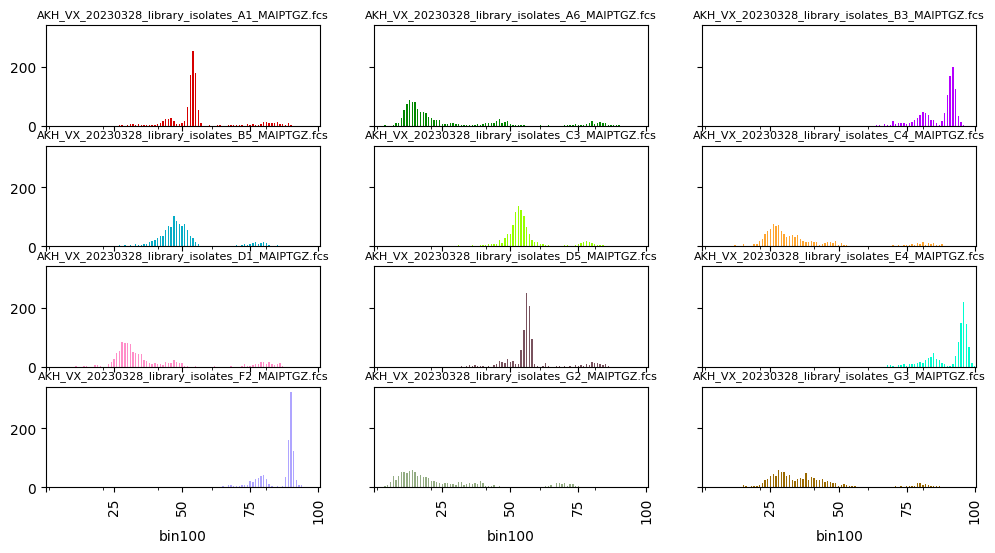

In [48]:
df = ret_dsorter['abundance_equal']['v_num_cells_encapsulated']['rate_dot5']['df'].copy()
columns = df.columns

colname_f1 = 'sum_mCherry-A'

df['AvgCell_mCherry-A'] = df[colname_f1] / df['num_cells_at_saturation_in_droplet']
df['CircularSlice_mCherry-A'] = df[colname_f1] * df['size_droplet'].apply(lambda x: 3/4/(x/2))

colname_f1 = 'CircularSlice_mCherry-A'
colname_f1 = 'AvgCell_mCherry-A'

colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

# demultiplex strains for multi-cell encapsulation
df.rename(columns={'sid':'sid_combo'}, inplace=True)
columns = df.columns
df_sid_demultiplexed = df['sid_combo'].apply(';'.join).str.split(';', expand=True)
df[df_sid_demultiplexed.columns] = df_sid_demultiplexed
dfm = df.melt(id_vars=columns, var_name='id_in_droplet', value_name='sid').dropna(subset=['sid'])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_equal']['v_num_cells_encapsulated']['rate_dot5_01']= DropletSorter.plot_histogram_highlighting_strains(
    df=dfm,
    colname_f1=colname_f1_xform,
    colname_strain='sid', #'sid
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=True,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_equal']['v_num_cells_encapsulated']['rate_dot5_01']= DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_equal']['v_num_cells_encapsulated']['rate_dot5_01']['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              colname_strain='sid',
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

###(3) random abundance

In [ ]:
ret_dsorter['abundance_random'] = {}

In [ ]:
# Generate random abundance and assign to df
#abundances_random = fld.generate_abuduance(a=3, scale=10, size=len(ls_wz))
abundances_random = [0.06016566, 0.02113162, 0.04187348, 0.26106276, 0.10405436, 0.04489549,
                     0.04325233, 0.03035451, 0.06089064, 0.11688058, 0.08055852, 0.13488005]
strain2P_random = dict(zip(ls_wz, abundances_random))

In [ ]:
tmp_ret = FlowData.assign_sampling_probability(dfc_wz, strain2P=strain2P_random) #, strain2P=strain2P)
# assign random abundance to strains in the collections
dfc_wz = tmp_ret['df']
print(pd.Series(tmp_ret['strain2P']).sort_index())

####control
<p>droplet size = 40 um
<p>num cells encapsulated = 1
<p>num events = 10000

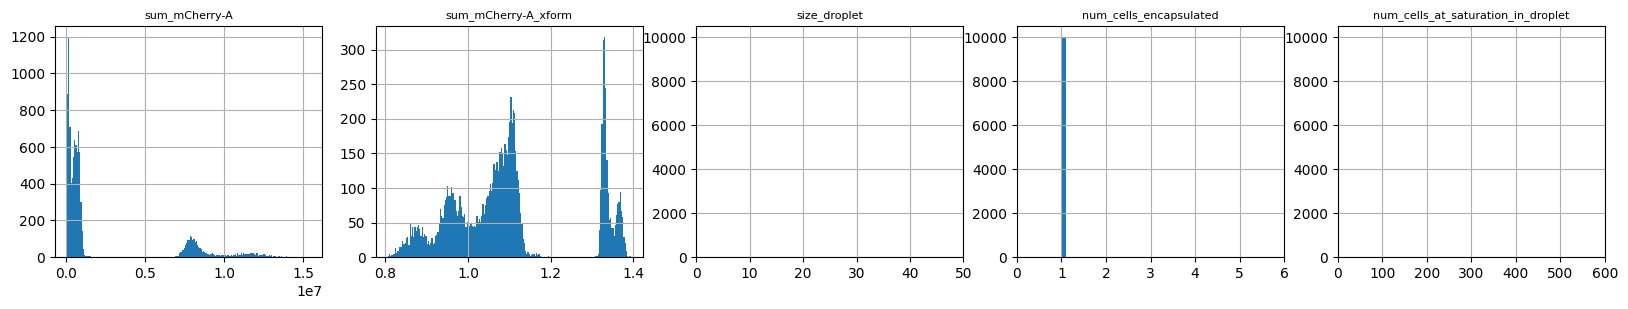

In [106]:
df = dfc_wz.copy()
colname_f1='mCherry-H'
colname_f1_xform= '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

ret_dsorter['abundance_random']['control']  = DropletSorter.culture_sort(
    df=df,
    n_rounds=10000,
    colname_f1=colname_f1,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    size_droplet=40,
    size_type='diameter',
    func_droplet_size=np.random.normal,
    scale_droplet_size=0,
    size_left_curve_only=False,
    bins=200,
    num_cells_encapsulated=1,
    func_cells_encapsulated_per_droplet=None, #np.random.poisson,
    cell_encapsulation_rate=0.1,
    discard_empty_droplets=True,
    rng=np.random.default_rng(),
    figsize=None)

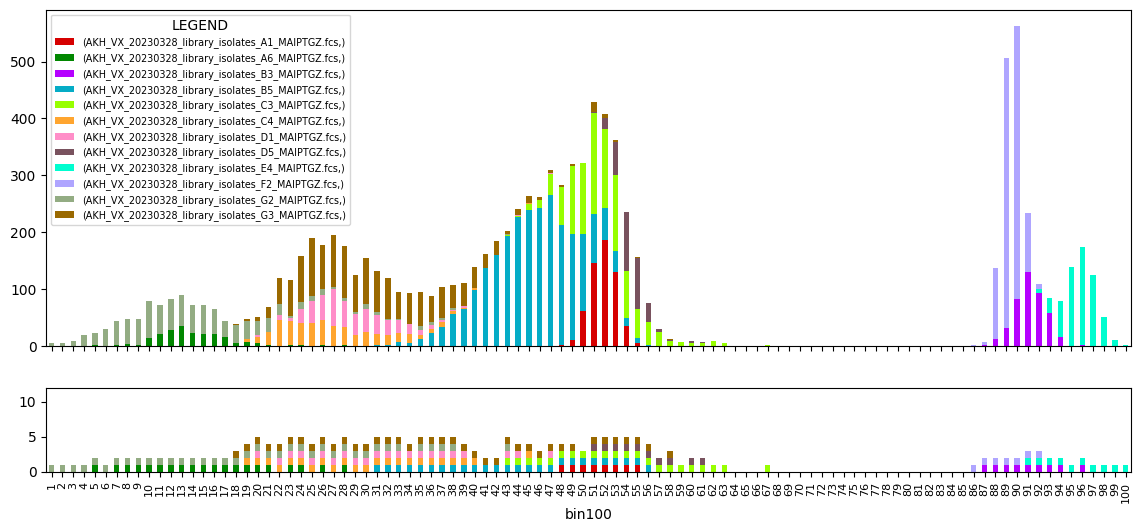

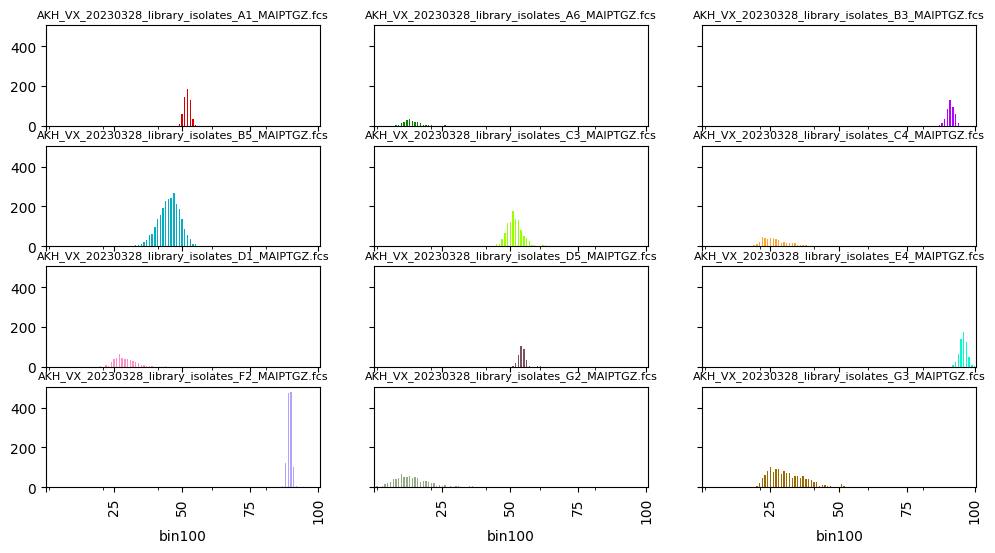

In [107]:
df = ret_dsorter['abundance_random']['control']['df']

colname_f1 = 'sum_mCherry-A'

df['AvgCell_mCherry-A'] = df[colname_f1] / df['num_cells_at_saturation_in_droplet']
df['CircularSlice_mCherry-A'] = df[colname_f1] * df['size_droplet'].apply(lambda x: 3/4/(x/2))

#colname_f1 = 'CircularSlice_mCherry-A'
#colname_f1 = 'AvgCell_mCherry-A'

colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_facs_03_control_01 = DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_facs_03_control_02 = DropletSorter.plot_histogram_strains_individual(
              df=ret_facs_03_control_01['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

#### varying mCherry signal measurement

In [108]:
ret_dsorter['abundance_random']['v_measurement'] = {}

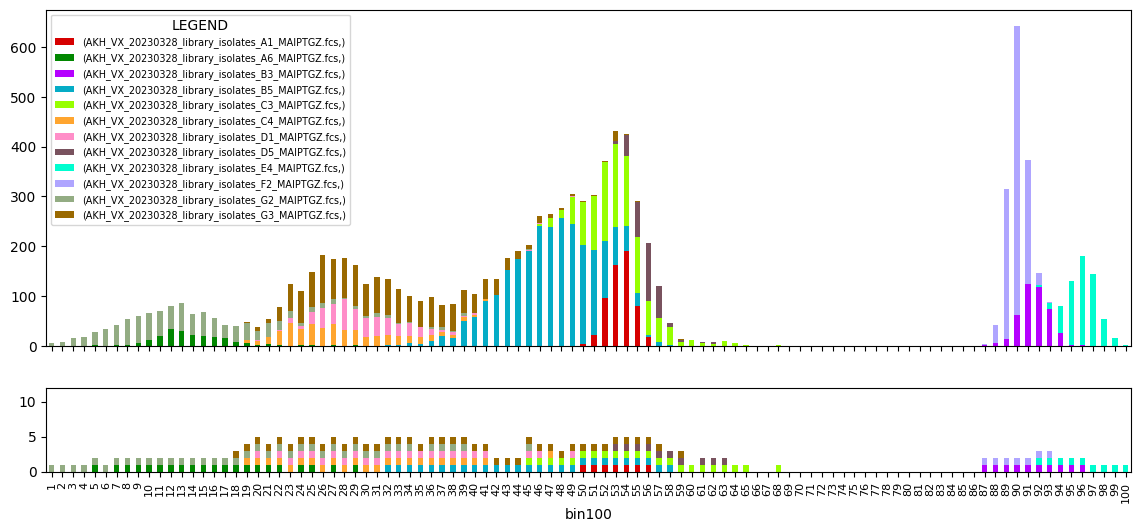

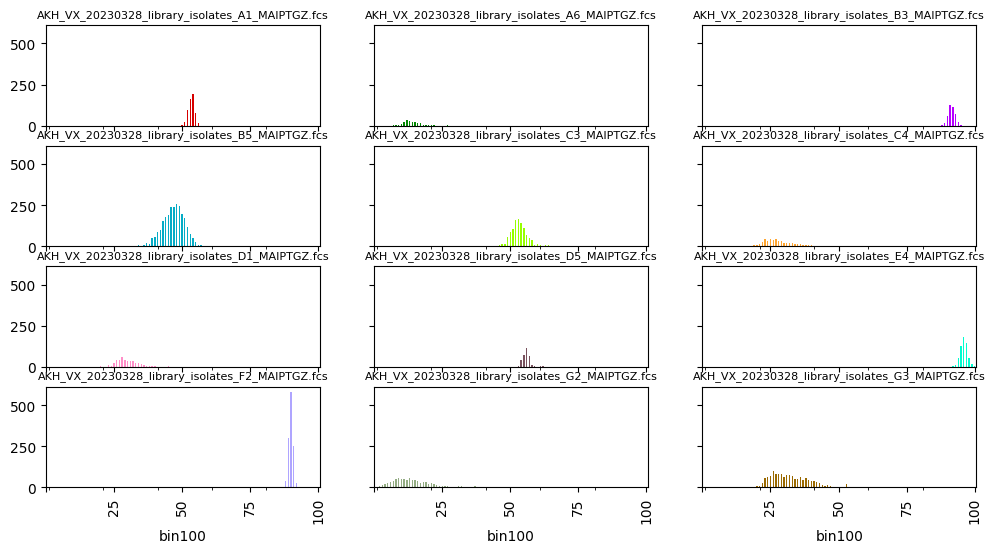

In [109]:
# In the control, mCherry-A signals from all cells are summed

# sum mCherry-A in droplet / num cells in droplet
df =  ret_dsorter['abundance_random']['control']['df'].copy()


colname_f1 = 'sum_mCherry-A'
df['AvgCell_mCherry-A'] = df[colname_f1] / df['num_cells_at_saturation_in_droplet']

colname_f1 = 'AvgCell_mCherry-A'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_random']['v_measurement'][colname_f1] = DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_random']['v_measurement'][colname_f1 + '_01'] = DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_random']['v_measurement'][colname_f1]['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

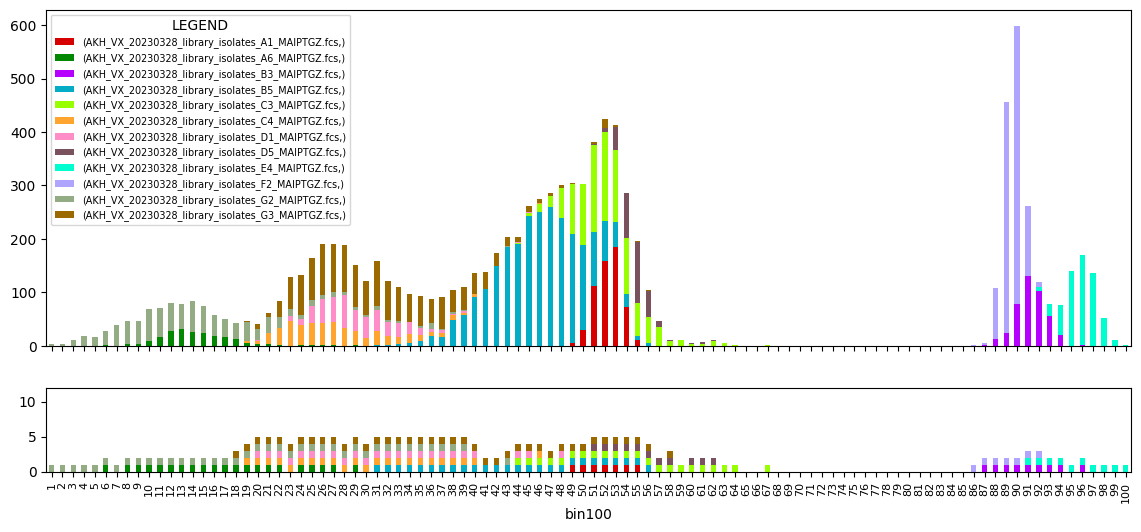

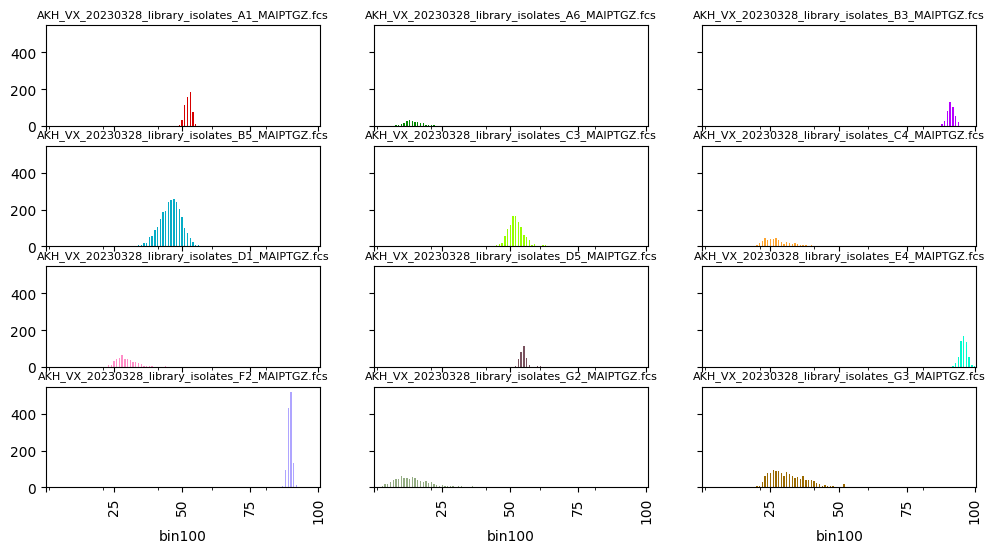

In [110]:
# In the control, mCherry-A signals from all cells are summed

# sum mCherry-A in droplet / ratio of largest slice to volume of the droplet, assuming slicing thickness of one
# (r**2*math.pi) / (r**3*math.pi*4/3) = 3/4/r = 3/4/r
df = ret_dsorter['abundance_random']['control']['df'].copy()


colname_f1 = 'sum_mCherry-A'
df['CircularSlice_mCherry-A'] = df[colname_f1] * df['size_droplet'].apply(lambda x: 3/4/(x/2))

colname_f1 = 'CircularSlice_mCherry-A'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_random']['v_measurement'][colname_f1] = DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_random']['v_measurement'][colname_f1 + '_01'] = DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_random']['v_measurement'][colname_f1]['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

#### varying cell size

In [111]:
ret_dsorter['abundance_random']['v_dropletsize'] = {}

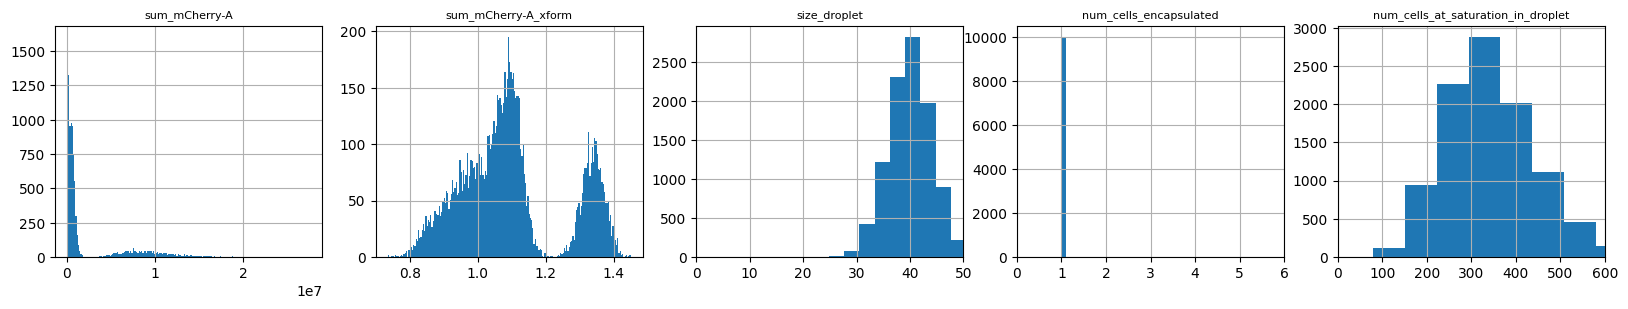

In [112]:
df = dfc_wz.copy()

colname_f1='mCherry-A'
colname_f1_xform= '{}_xform'.format(colname_f1)

ret_dsorter['abundance_random']['v_dropletsize']['scale_dot1'] = DropletSorter.culture_sort(
    df=df,
    n_rounds=10000,
    colname_f1=colname_f1,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    size_droplet=40,
    size_type='diameter',
    func_droplet_size=np.random.normal,
    scale_droplet_size=0.1,
    size_left_curve_only=False,
    bins=200,
    num_cells_encapsulated=1,
    func_cells_encapsulated_per_droplet=None, #np.random.poisson,
    cell_encapsulation_rate=0.1,
    discard_empty_droplets=True,
    rng=np.random.default_rng(),
    figsize=None)

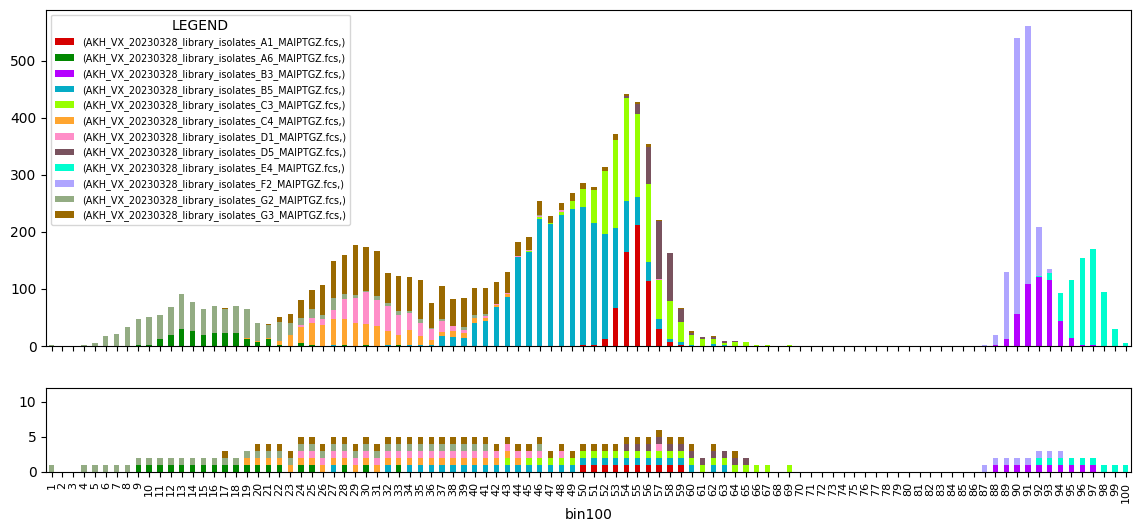

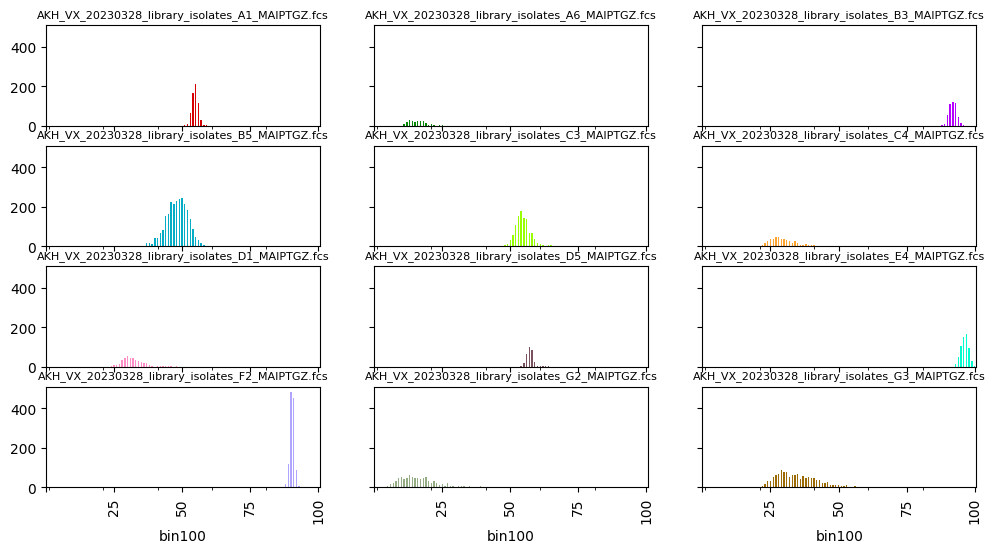

In [113]:
# droplet size scale =0.1
df = ret_dsorter['abundance_random']['v_dropletsize']['scale_dot1']['df'].copy()

colname_f1 = 'sum_mCherry-A'

df['AvgCell_mCherry-A'] = df[colname_f1] / df['num_cells_at_saturation_in_droplet']
df['CircularSlice_mCherry-A'] = df[colname_f1] * df['size_droplet'].apply(lambda x: 3/4/(x/2))

colname_f1 = 'CircularSlice_mCherry-A'
colname_f1 = 'AvgCell_mCherry-A'

colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_random']['v_dropletsize']['scale_dot1_01']= DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_random']['v_dropletsize']['scale_dot1_02']= DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_random']['v_dropletsize']['scale_dot1_01']['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

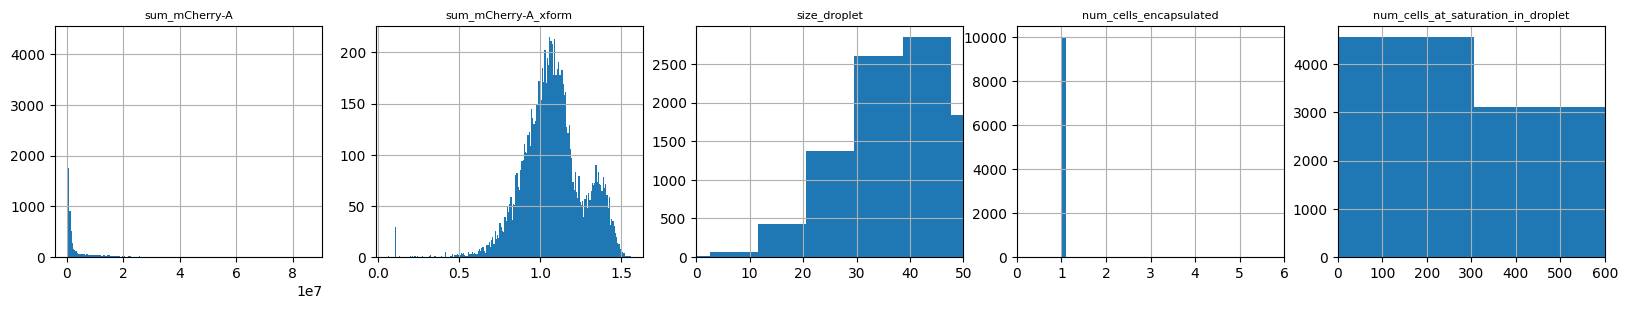

In [114]:
df = dfc_wz.copy()

colname_f1='mCherry-A'
colname_f1_xform= '{}_xform'.format(colname_f1)

ret_dsorter['abundance_random']['v_dropletsize']['scale_dot3'] = DropletSorter.culture_sort(
    df=df,
    n_rounds=10000,
    colname_f1=colname_f1,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    size_droplet=40,
    size_type='diameter',
    func_droplet_size=np.random.normal,
    scale_droplet_size=0.3,
    size_left_curve_only=False,
    bins=200,
    num_cells_encapsulated=1,
    func_cells_encapsulated_per_droplet=None, #np.random.poisson,
    cell_encapsulation_rate=0.1,
    discard_empty_droplets=True,
    rng=np.random.default_rng(),
    figsize=None)

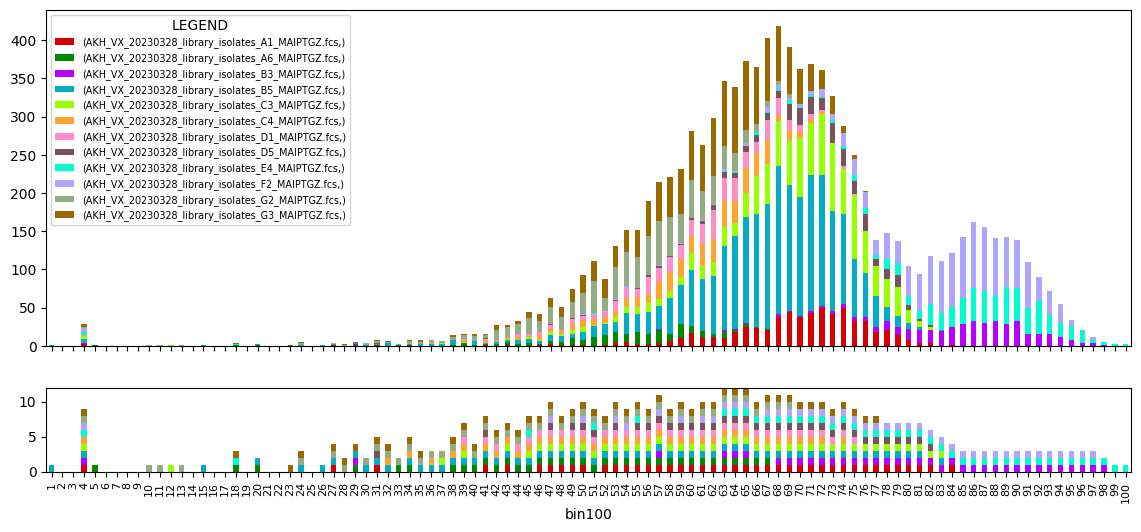

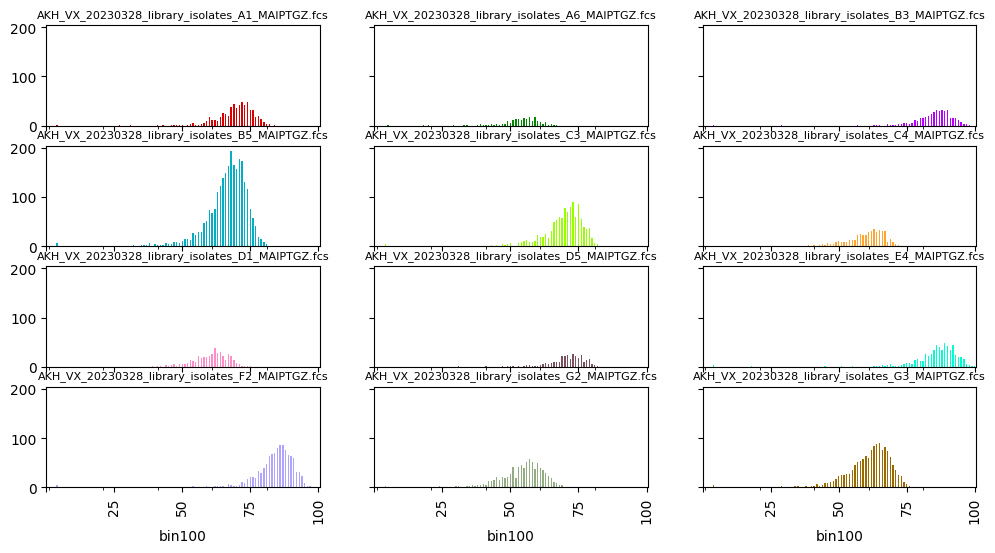

In [115]:
df = ret_dsorter['abundance_random']['v_dropletsize']['scale_dot3']['df'].copy()

colname_f1 = 'sum_mCherry-A'

df['AvgCell_mCherry-A'] = df[colname_f1] / df['num_cells_at_saturation_in_droplet']
df['CircularSlice_mCherry-A'] = df[colname_f1] * df['size_droplet'].apply(lambda x: 3/4/(x/2))

#colname_f1 = 'CircularSlice_mCherry-A'
#colname_f1 = 'AvgCell_mCherry-A'

colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_random']['v_dropletsize']['scale_dot3_01']= DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_random']['v_dropletsize']['scale_dot3_02']= DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_random']['v_dropletsize']['scale_dot3_01']['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

#### varying num cells encapsulated

In [116]:
ret_dsorter['abundance_random']['v_num_cells_encapsulated'] = {}

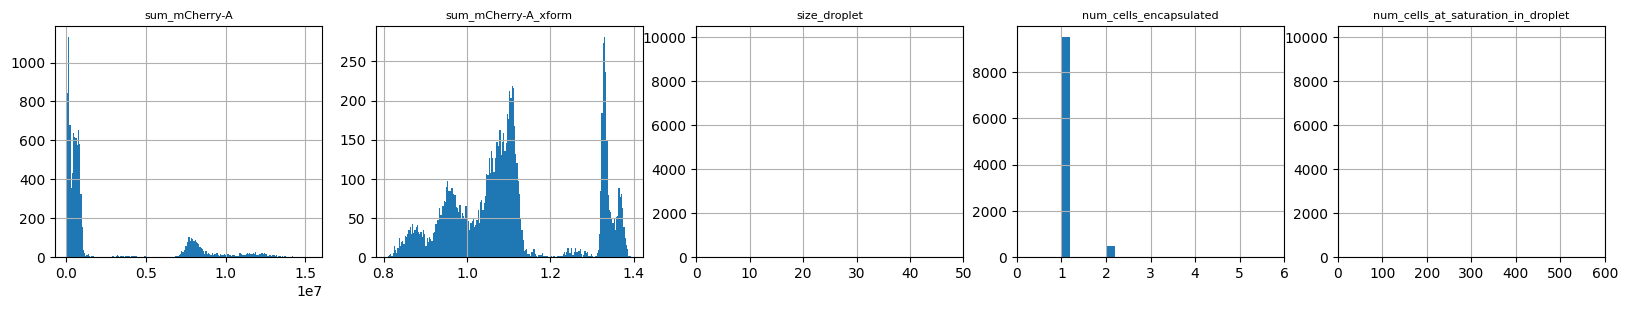

In [117]:
df = dfc_wz.copy()
colname_f1='mCherry-A'
colname_f1_xform= '{}_xform'.format(colname_f1)

ret_dsorter['abundance_random']['v_num_cells_encapsulated']['rate_dot1'] = DropletSorter.culture_sort(
    df=df,
    n_rounds=10000,
    colname_f1=colname_f1,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    size_droplet=40,
    size_type='diameter',
    func_droplet_size=np.random.normal,
    scale_droplet_size=0,
    size_left_curve_only=False,
    bins=200,
    num_cells_encapsulated=1,
    func_cells_encapsulated_per_droplet=np.random.poisson,
    cell_encapsulation_rate=0.1,
    discard_empty_droplets=True,
    rng=np.random.default_rng(),
    figsize=None)

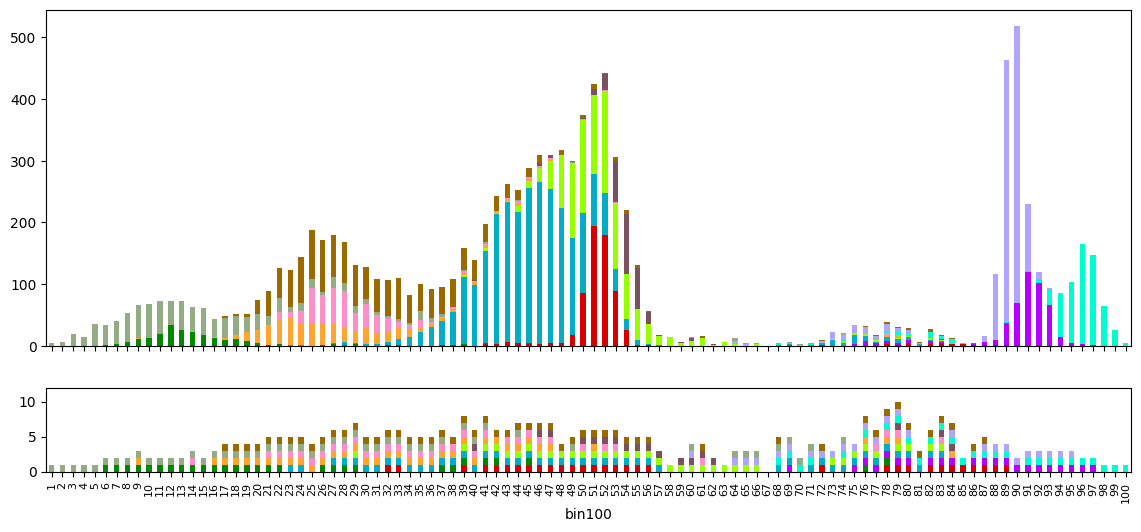

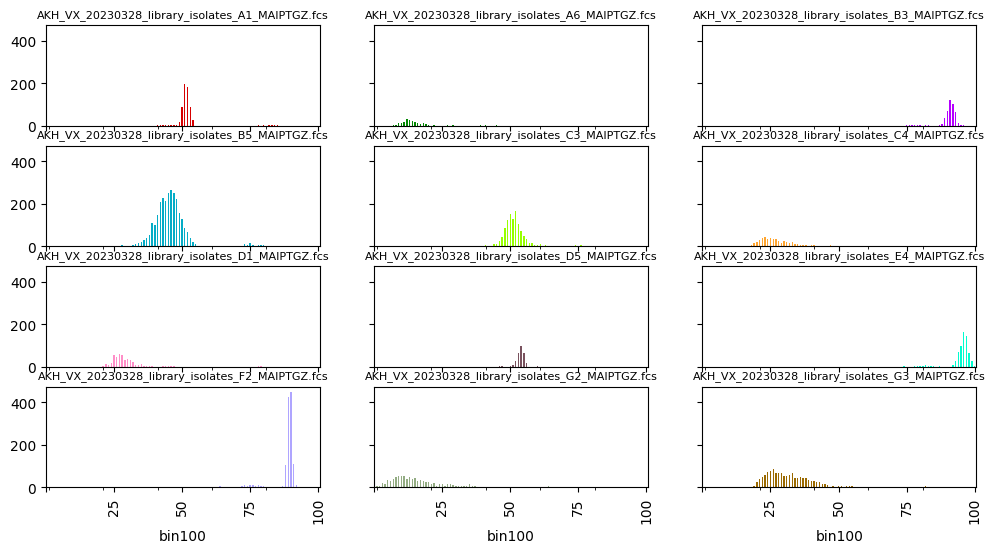

In [118]:
df = ret_dsorter['abundance_random']['v_num_cells_encapsulated']['rate_dot1']['df'].copy()
columns = df.columns

colname_f1 = 'sum_mCherry-A'

df['AvgCell_mCherry-A'] = df[colname_f1] / df['num_cells_at_saturation_in_droplet']
df['CircularSlice_mCherry-A'] = df[colname_f1] * df['size_droplet'].apply(lambda x: 3/4/(x/2))

#colname_f1 = 'CircularSlice_mCherry-A'
#colname_f1 = 'AvgCell_mCherry-A'

colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

# demultiplex strains for multi-cell encapsulation
df.rename(columns={'sid':'sid_combo'}, inplace=True)
columns = df.columns
df_sid_demultiplexed = df['sid_combo'].apply(';'.join).str.split(';', expand=True)
df[df_sid_demultiplexed.columns] = df_sid_demultiplexed
dfm = df.melt(id_vars=columns, var_name='id_in_droplet', value_name='sid').dropna(subset=['sid'])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_random']['v_num_cells_encapsulated']['rate_dot1_01']= DropletSorter.plot_histogram_highlighting_strains(
    df=dfm,
    colname_f1=colname_f1_xform,
    colname_strain='sid', #'sid
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=True,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_random']['v_num_cells_encapsulated']['rate_dot1_01']= DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_random']['v_num_cells_encapsulated']['rate_dot1_01']['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              colname_strain='sid',
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

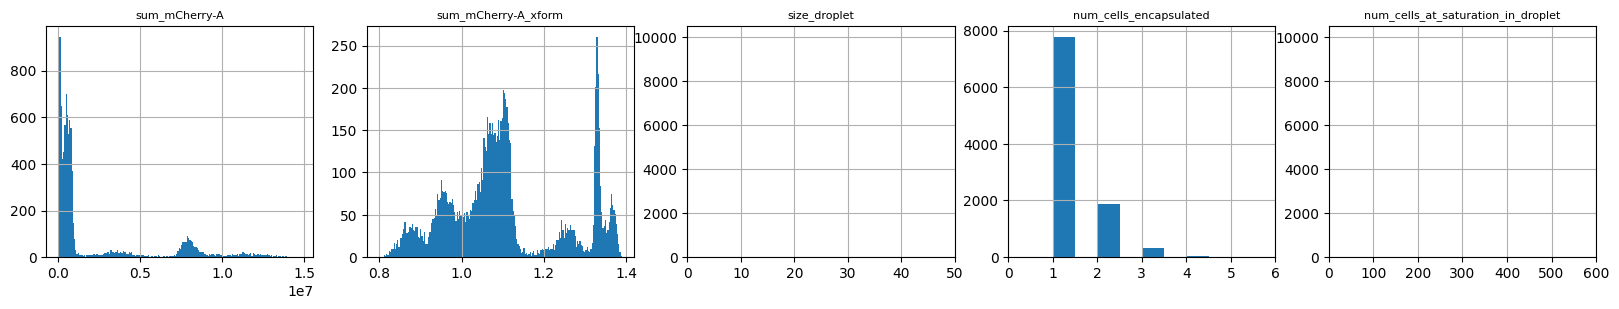

In [119]:
df = dfc_wz.copy()
colname_f1='mCherry-A'
colname_f1_xform= '{}_xform'.format(colname_f1)

ret_dsorter['abundance_random']['v_num_cells_encapsulated']['rate_dot5'] = DropletSorter.culture_sort(
    df=df,
    n_rounds=10000,
    colname_f1=colname_f1,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    size_droplet=40,
    size_type='diameter',
    func_droplet_size=np.random.normal,
    scale_droplet_size=0,
    size_left_curve_only=False,
    bins=200,
    num_cells_encapsulated=1,
    func_cells_encapsulated_per_droplet=np.random.poisson,
    cell_encapsulation_rate=0.5,
    discard_empty_droplets=True,
    rng=np.random.default_rng(),
    figsize=None)

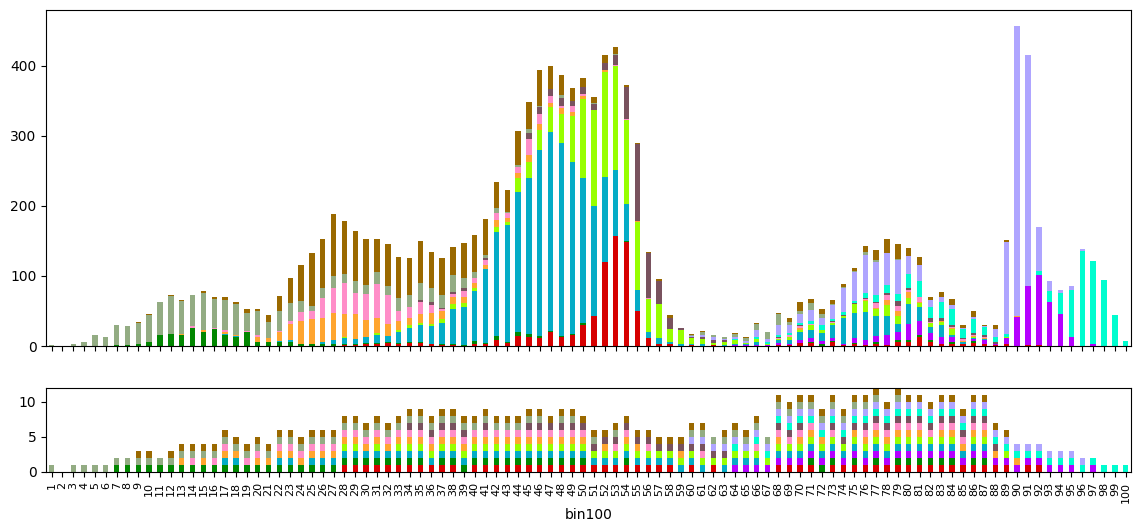

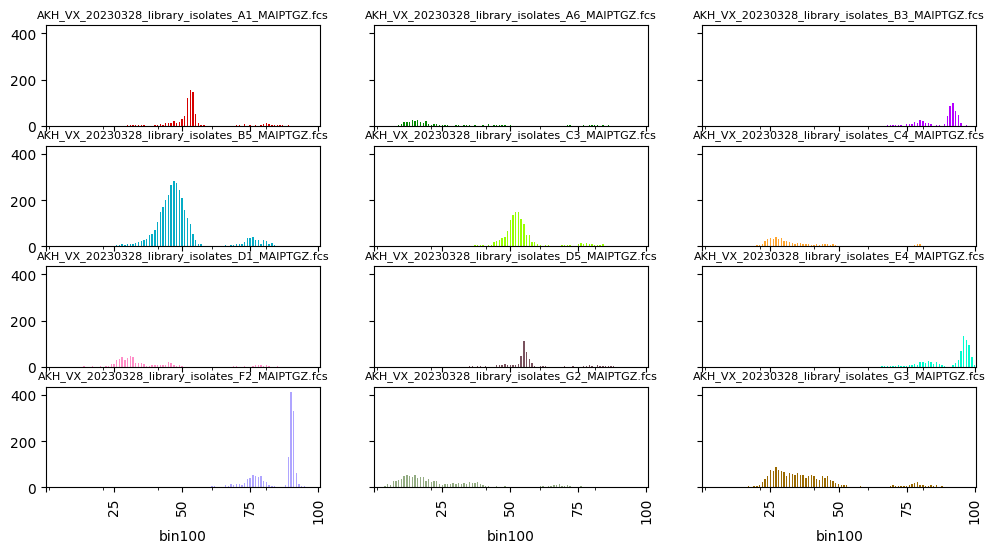

In [120]:
df = ret_dsorter['abundance_random']['v_num_cells_encapsulated']['rate_dot5']['df'].copy()
columns = df.columns

colname_f1 = 'sum_mCherry-A'

df['AvgCell_mCherry-A'] = df[colname_f1] / df['num_cells_at_saturation_in_droplet']
df['CircularSlice_mCherry-A'] = df[colname_f1] * df['size_droplet'].apply(lambda x: 3/4/(x/2))

colname_f1 = 'CircularSlice_mCherry-A'
#colname_f1 = 'AvgCell_mCherry-A'

colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

# demultiplex strains for multi-cell encapsulation
df.rename(columns={'sid':'sid_combo'}, inplace=True)
columns = df.columns
df_sid_demultiplexed = df['sid_combo'].apply(';'.join).str.split(';', expand=True)
df[df_sid_demultiplexed.columns] = df_sid_demultiplexed
dfm = df.melt(id_vars=columns, var_name='id_in_droplet', value_name='sid').dropna(subset=['sid'])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_random']['v_num_cells_encapsulated']['rate_dot5_01']= DropletSorter.plot_histogram_highlighting_strains(
    df=dfm,
    colname_f1=colname_f1_xform,
    colname_strain='sid', #'sid
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=True,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_random']['v_num_cells_encapsulated']['rate_dot5_01']= DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_random']['v_num_cells_encapsulated']['rate_dot5_01']['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              colname_strain='sid',
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

#### varying cell size + num cells encapsulated

In [121]:
ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated'] = {}

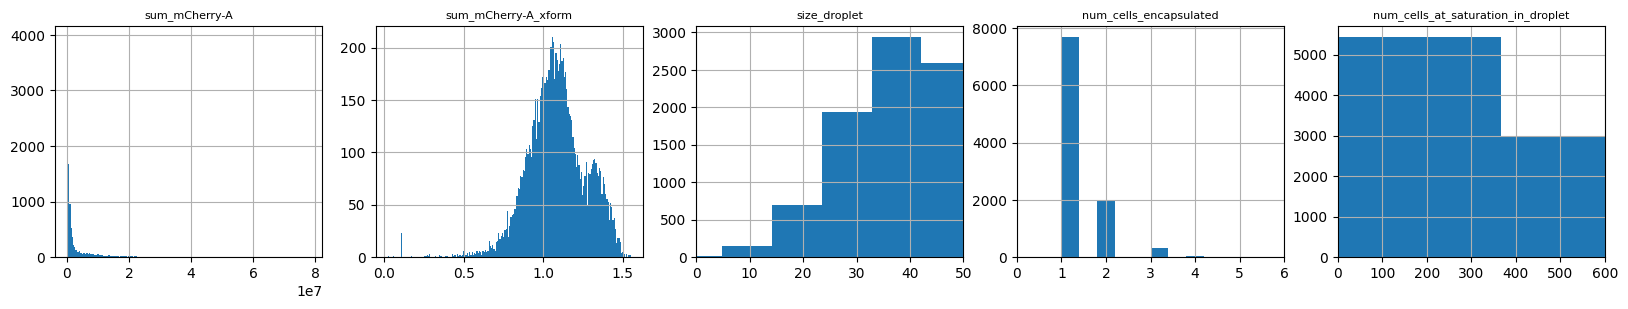

In [122]:
df = dfc_wz.copy()
colname_f1='mCherry-A'
colname_f1_xform= '{}_xform'.format(colname_f1)

ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot3_rate_dot5'] = DropletSorter.culture_sort(
    df=df,
    n_rounds=10000,
    colname_f1=colname_f1,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    size_droplet=40,
    size_type='diameter',
    func_droplet_size=np.random.normal,
    scale_droplet_size=0.3,
    size_left_curve_only=False,
    bins=200,
    num_cells_encapsulated=1,
    func_cells_encapsulated_per_droplet=np.random.poisson,
    cell_encapsulation_rate=0.5,
    discard_empty_droplets=True,
    rng=np.random.default_rng(),
    figsize=None)

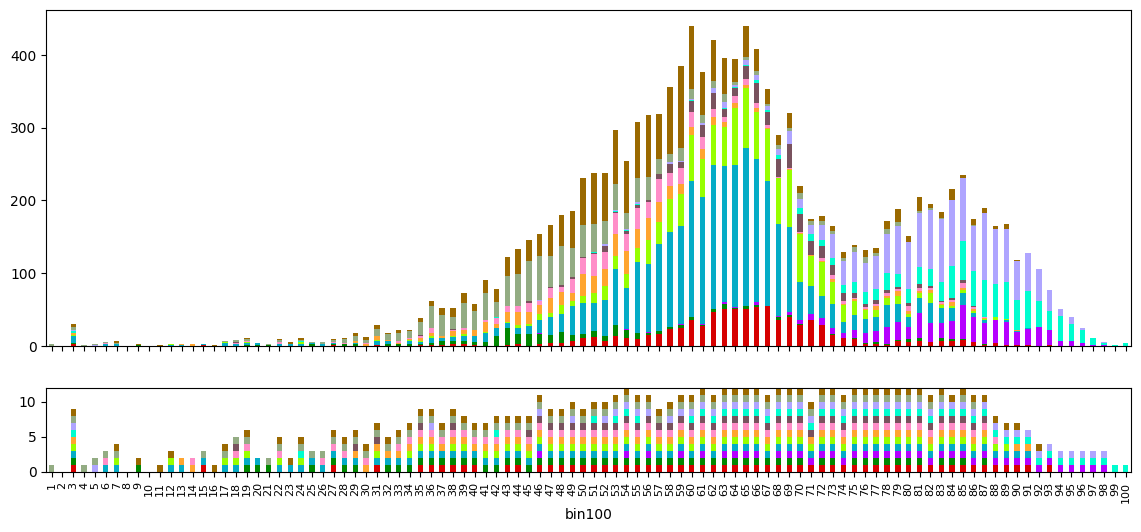

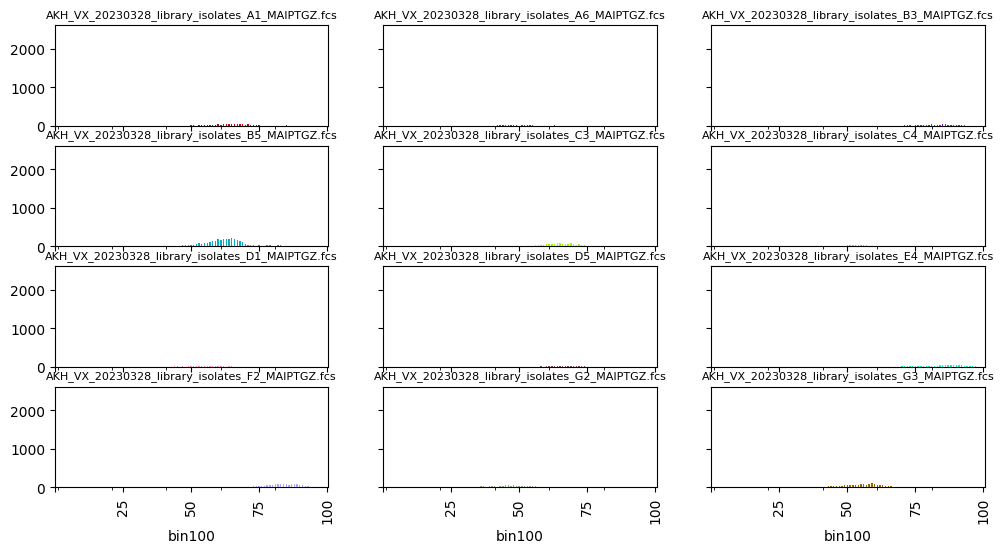

In [123]:
df = ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot3_rate_dot5']['df'].copy()
columns = df.columns

colname_f1 = 'sum_mCherry-A'

df['AvgCell_mCherry-A'] = df[colname_f1] / df['num_cells_at_saturation_in_droplet']
df['CircularSlice_mCherry-A'] = df[colname_f1] * df['size_droplet'].apply(lambda x: 3/4/(x/2))

colname_f1 = 'CircularSlice_mCherry-A'
#colname_f1 = 'AvgCell_mCherry-A'

colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

# demultiplex strains for multi-cell encapsulation
df.rename(columns={'sid':'sid_combo'}, inplace=True)
columns = df.columns
df_sid_demultiplexed = df['sid_combo'].apply(';'.join).str.split(';', expand=True)
df[df_sid_demultiplexed.columns] = df_sid_demultiplexed
dfm = df.melt(id_vars=columns, var_name='id_in_droplet', value_name='sid').dropna(subset=['sid'])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot3_rate_dot5_01']= DropletSorter.plot_histogram_highlighting_strains(
    df=dfm,
    colname_f1=colname_f1_xform,
    colname_strain='sid', #'sid
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    #ylim=(0,50),
    font_size='x-small',
    remove_legend=True,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot3_rate_dot5_02']= DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot3_rate_dot5_01']['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              colname_strain='sid',
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              fontsize=10,
              size_title=8,
              )

In [124]:
ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot3_rate_dot5_02']['dfstrain']

,indicies_padded,values_padded,sid_combo,num_cells_encapsulated,size_droplet,v_droplet_pl_t0,num_cells_at_saturation_in_droplet,sum_mCherry-A,sum_mCherry-A_xform,AvgCell_mCherry-A,CircularSlice_mCherry-A,CircularSlice_mCherry-A_xform,id_in_droplet,sid,bin,bin100
1945,"[199551, 196853, 204230, 200478, 199719, 19551...","[350.0, 322.0, 324.0, 1684.0, 317.0, -8.0, 54....",(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,1,30.925944,15.487008,154,120352.0,0.924823,781.506494,5837.428879,0.631226,0,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,"(0.629, 0.64]",51
1946,"[192109, 193146, 203224, 200649, 200555, 19282...","[641.0, -15.0, 119.0, 86.0, 183.0, 921.0, 50.0...",(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,1,32.389625,17.791657,177,92674.0,0.899577,523.581921,4291.837241,0.600991,0,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,"(0.597, 0.608]",48
1947,"[204605, 196564, 193750, 200343, 200092, 20371...","[1511.0, 280.0, 126.0, -25.0, 166.0, 253.0, 11...",(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,1,38.973679,30.996514,309,188713.0,0.968265,610.721683,7263.094077,0.652621,0,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,"(0.651, 0.662]",53
1948,"[193273, 191112, 190800, 193504, 193074, 19656...","[273.0, 657.0, -106.0, 444.0, 293.0, 238.0, 66...",(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,1,30.936118,15.502298,155,203267.0,0.975439,1311.400000,9855.809927,0.682417,0,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,"(0.673, 0.684]",55
1949,"[202333, 191638, 194882, 197129, 197923, 19302...","[245.0, -17.0, 96.0, -92.0, 376.0, 1336.0, 269...",(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,1,38.098170,28.954160,289,248731.0,0.994929,860.660900,9793.029402,0.681794,0,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,"(0.673, 0.684]",55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39983,"[196002, 199023, 196271, 46700, 199951, 201130...","[354.0, -16.0, 4881.0, -51.0, 266.0, 212.0, 52...",(AKH_VX_20230328_library_isolates_B5_MAIPTGZ.f...,4,37.265936,27.097842,270,263600.0,1.000535,976.296296,10610.226055,0.689603,3,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,"(0.684, 0.694]",56
39984,"[47758, 52183, 40658, 191409, 192650, 45249, 4...","[26341.0, -66.0, 5022.0, 69.0, 702.0, 338.0, 1...",(AKH_VX_20230328_library_isolates_B5_MAIPTGZ.f...,4,54.880365,86.546517,865,1252179.0,1.150948,1447.605780,34224.781497,0.803255,3,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,"(0.803, 0.814]",67
39987,"[52585, 195197, 47667, 202385, 203317, 41507, ...","[-125.0, 440.0, 85.0, 160.0, 1243.0, 211.0, -6...",(AKH_VX_20230328_library_isolates_B5_MAIPTGZ.f...,4,33.022897,18.855764,188,119825.0,0.924399,637.367021,5442.814455,0.624359,3,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,"(0.618, 0.629]",50
39992,"[44982, 44217, 47191, 41417, 44747, 42522, 193...","[7.0, 876.0, -2.0, -31.0, 185.0, 194.0, 124.0,...",(AKH_VX_20230328_library_isolates_B5_MAIPTGZ.f...,4,10.813105,0.661988,6,1229.0,0.475605,204.833333,170.487564,0.264268,3,(AKH_VX_20230328_library_isolates_G3_MAIPTGZ.f...,"(0.26, 0.271]",17


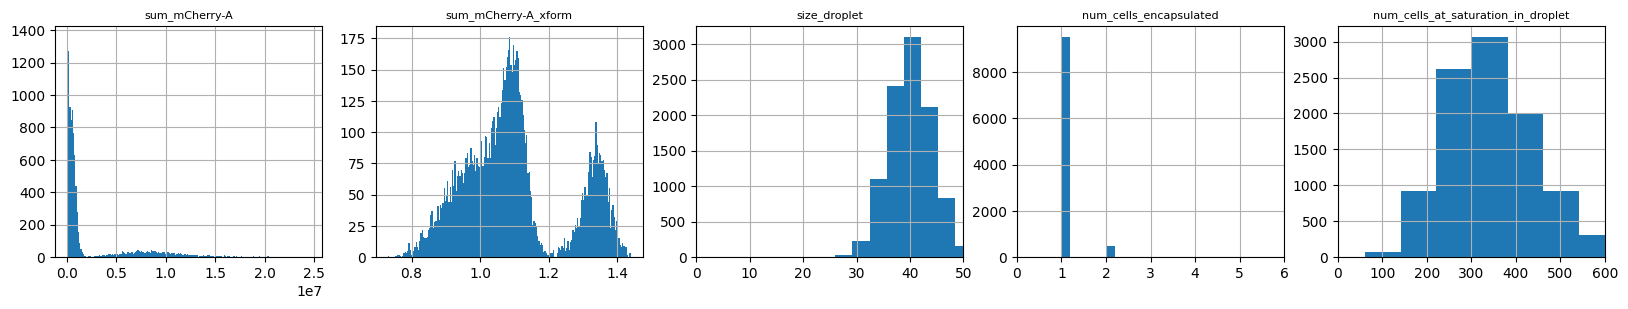

In [125]:
df = dfc_wz.copy()
colname_f1='mCherry-A'
colname_f1_xform= '{}_xform'.format(colname_f1)

ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot1_rate_dot1'] = DropletSorter.culture_sort(
    df=df,
    n_rounds=10000,
    colname_f1=colname_f1,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    size_droplet=40,
    size_type='diameter',
    func_droplet_size=np.random.normal,
    scale_droplet_size=0.1,
    size_left_curve_only=False,
    bins=200,
    num_cells_encapsulated=1,
    func_cells_encapsulated_per_droplet=np.random.poisson,
    cell_encapsulation_rate=0.1,
    discard_empty_droplets=True,
    rng=np.random.default_rng(),
    figsize=None)

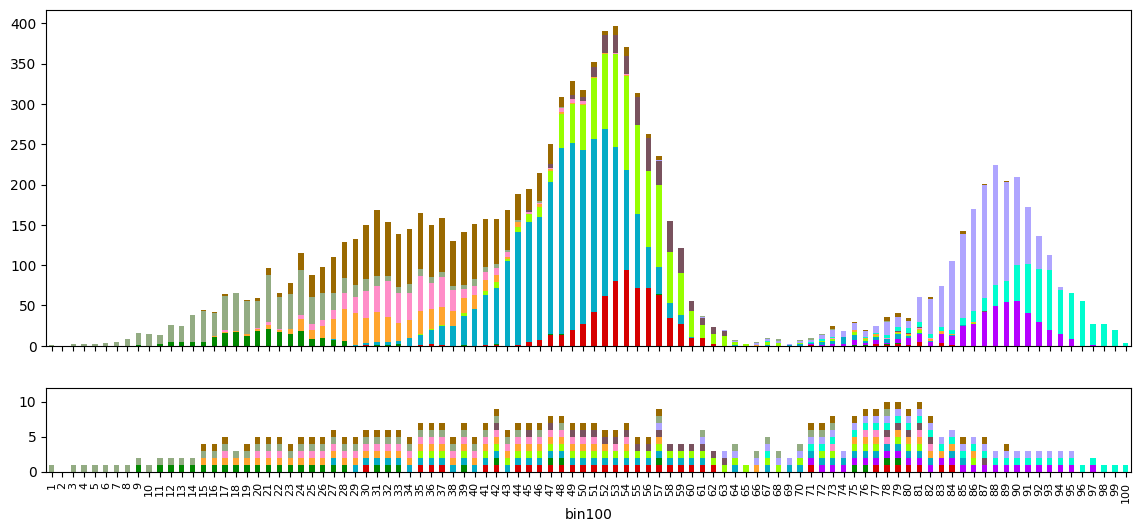

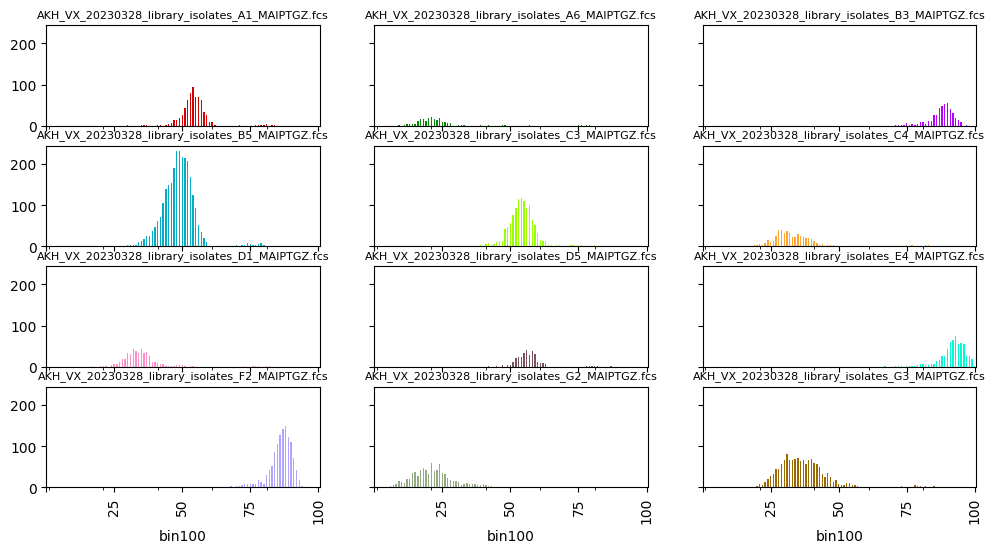

In [126]:
df = ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot1_rate_dot1']['df'].copy()
columns = df.columns

colname_f1 = 'sum_mCherry-A'

df['AvgCell_mCherry-A'] = df[colname_f1] / df['num_cells_at_saturation_in_droplet']
df['CircularSlice_mCherry-A'] = df[colname_f1] * df['size_droplet'].apply(lambda x: 3/4/(x/2))

colname_f1 = 'CircularSlice_mCherry-A'
#colname_f1 = 'AvgCell_mCherry-A'

colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

# demultiplex strains for multi-cell encapsulation
df.rename(columns={'sid':'sid_combo'}, inplace=True)
columns = df.columns
df_sid_demultiplexed = df['sid_combo'].apply(';'.join).str.split(';', expand=True)
df[df_sid_demultiplexed.columns] = df_sid_demultiplexed
dfm = df.melt(id_vars=columns, var_name='id_in_droplet', value_name='sid').dropna(subset=['sid'])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot1_rate_dot1_01']= DropletSorter.plot_histogram_highlighting_strains(
    df=dfm,
    colname_f1=colname_f1_xform,
    colname_strain='sid', #'sid
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=True,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot1_rate_dot1_02']= DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot1_rate_dot1_01']['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              colname_strain='sid',
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

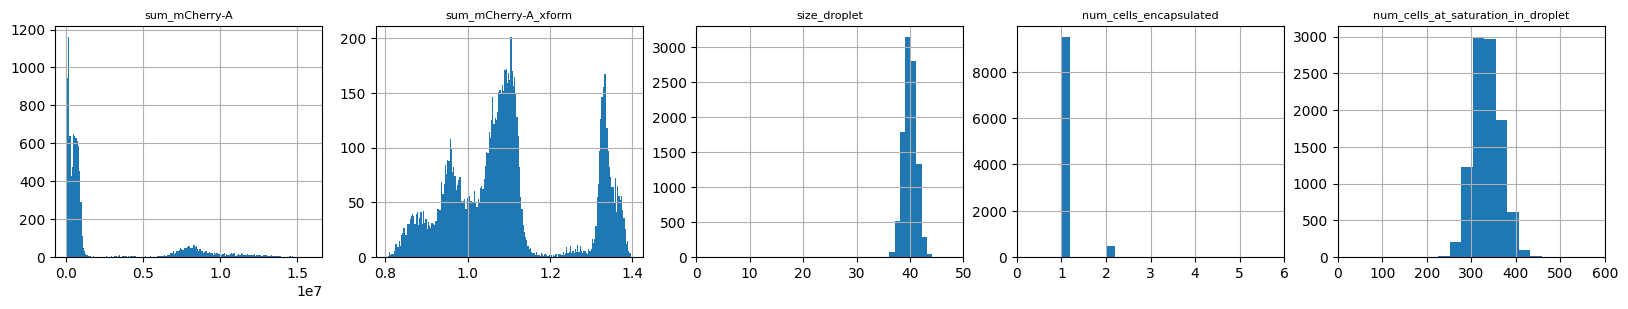

In [127]:
df = dfc_wz.copy()
colname_f1='mCherry-A'
colname_f1_xform= '{}_xform'.format(colname_f1)

ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot03_rate_dot1'] = DropletSorter.culture_sort(
    df=df,
    n_rounds=10000,
    colname_f1=colname_f1,
    colname_strain='sid',
    colname_strainP='P_sampling_sid',
    colname_indexP='P_sampling_index',
    size_droplet=40,
    size_type='diameter',
    func_droplet_size=np.random.normal,
    scale_droplet_size=0.03,
    size_left_curve_only=False,
    bins=200,
    num_cells_encapsulated=1,
    func_cells_encapsulated_per_droplet=np.random.poisson,
    cell_encapsulation_rate=0.1,
    discard_empty_droplets=True,
    rng=np.random.default_rng(),
    figsize=None)

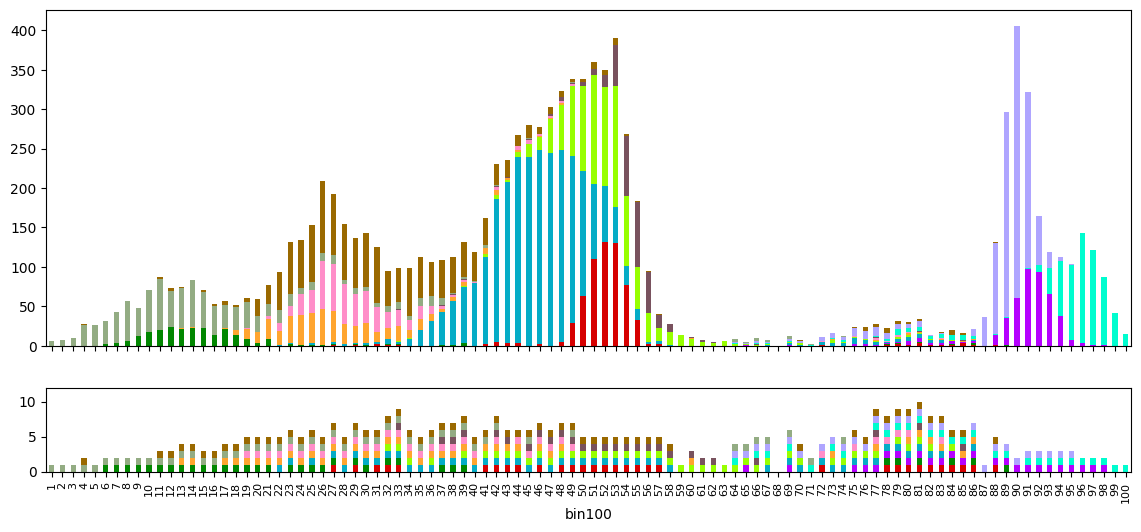

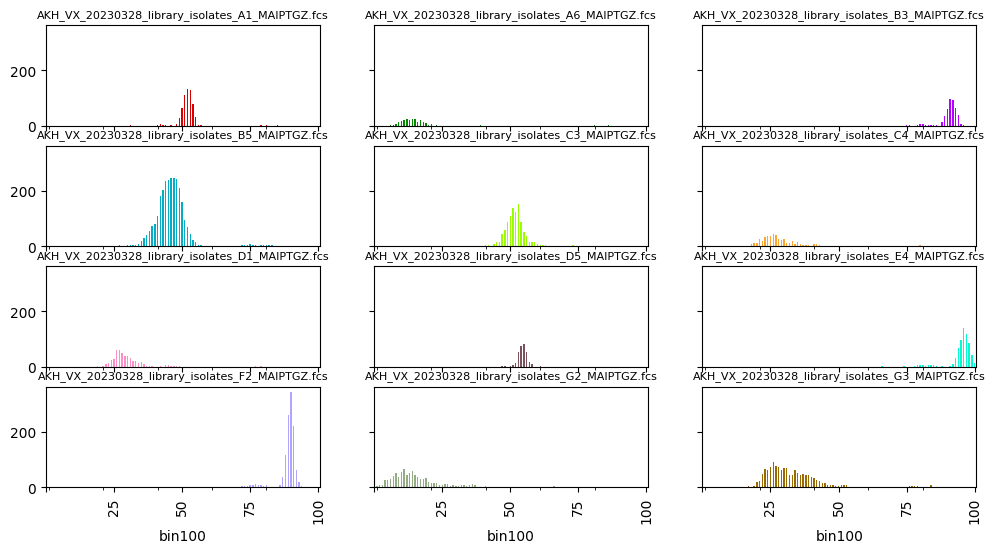

In [128]:
df = ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot03_rate_dot1']['df'].copy()
columns = df.columns

colname_f1 = 'sum_mCherry-A'

df['AvgCell_mCherry-A'] = df[colname_f1] / df['num_cells_at_saturation_in_droplet']
df['CircularSlice_mCherry-A'] = df[colname_f1] * df['size_droplet'].apply(lambda x: 3/4/(x/2))

colname_f1 = 'CircularSlice_mCherry-A'
#colname_f1 = 'AvgCell_mCherry-A'

colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])

# demultiplex strains for multi-cell encapsulation
df.rename(columns={'sid':'sid_combo'}, inplace=True)
columns = df.columns
df_sid_demultiplexed = df['sid_combo'].apply(';'.join).str.split(';', expand=True)
df[df_sid_demultiplexed.columns] = df_sid_demultiplexed
dfm = df.melt(id_vars=columns, var_name='id_in_droplet', value_name='sid').dropna(subset=['sid'])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot03_rate_dot1_01']= DropletSorter.plot_histogram_highlighting_strains(
    df=dfm,
    colname_f1=colname_f1_xform,
    colname_strain='sid', #'sid
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=True,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot03_rate_dot1_02']= DropletSorter.plot_histogram_strains_individual(
              df=ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot03_rate_dot1_01']['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              colname_strain='sid',
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

## Droplet Culture Merged + FACS

### (1) equal abundance

In [129]:
df = DropletSorter.merge_droplets(ret_dsorter['abundance_equal']['v_num_cells_encapsulated']['rate_dot1_01']['df'], dfc_wz)

KeyError: ignored

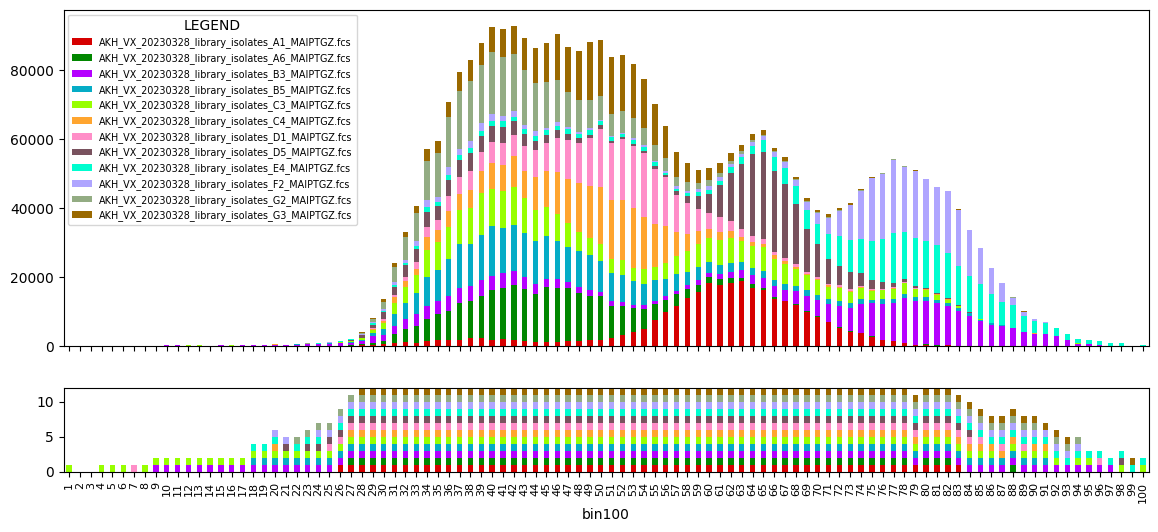

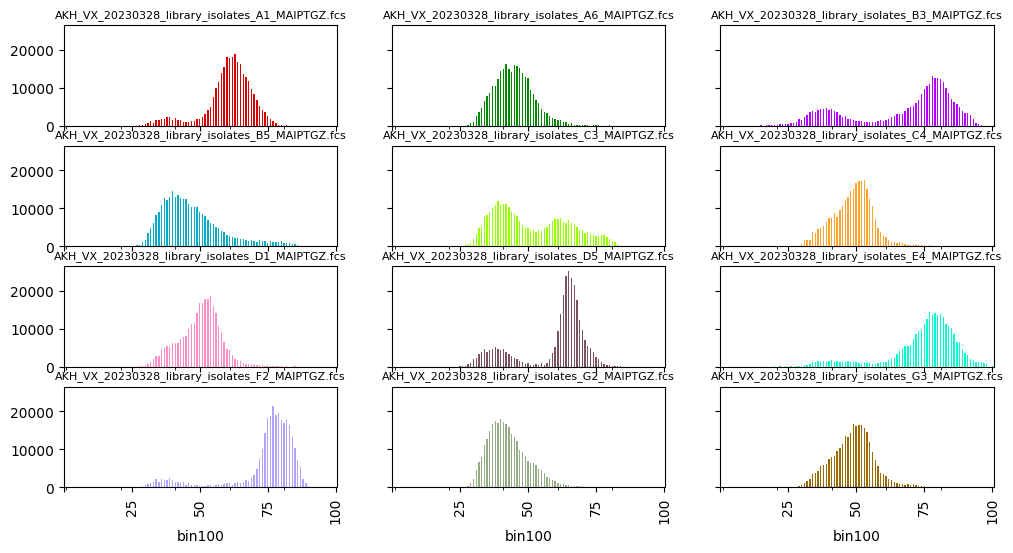

In [ ]:
colname_f1 = 'mCherry-H'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dmerged_01 = DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dmerged_01a = DropletSorter.plot_histogram_strains_individual(
              df=ret_dmerged_01['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

### (3) random abundance

#### varying num cells encapsualated

In [ ]:
df = DropletSorter.merge_droplets(ret_dsorter['abundance_random']['v_num_cells_encapsulated']['rate_dot1']['df'], dfc_wz)

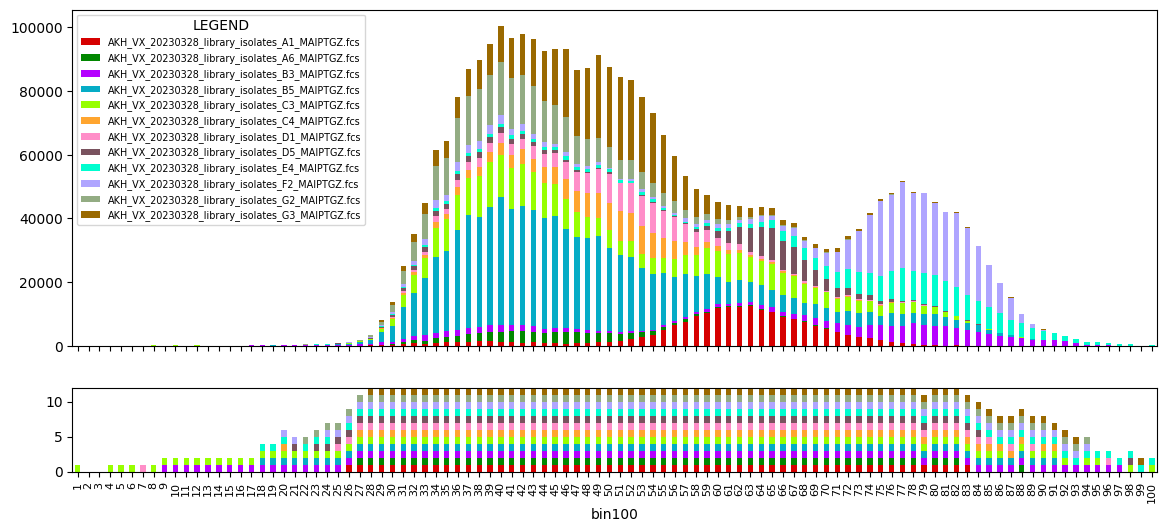

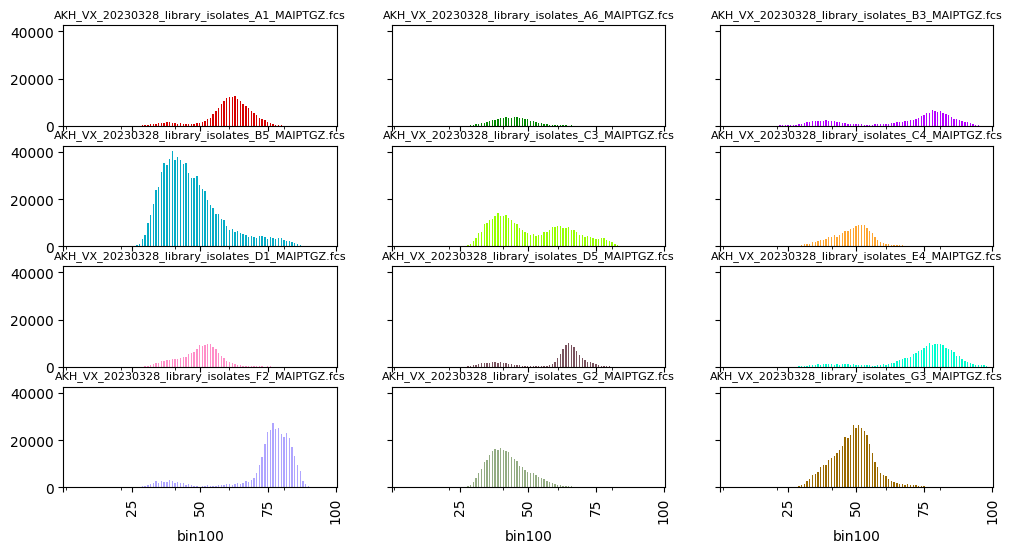

In [ ]:
colname_f1 = 'mCherry-A'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dmerged_03 = DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dmerged_03a = DropletSorter.plot_histogram_strains_individual(
              df=ret_dmerged_01['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )

####varying cell size + num cells encapsulated

In [ ]:
df = DropletSorter.merge_droplets(ret_dsorter['abundance_random']['v_dropletsize_and_num_cells_encapsulated']['scale_dot3_rate_dot5_01']['df'], dfc_wz)

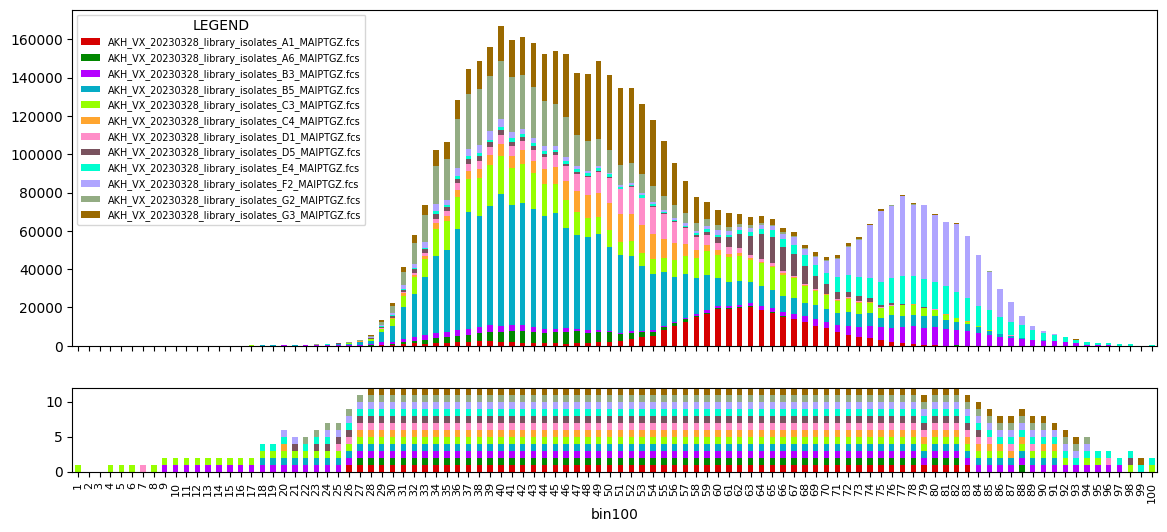

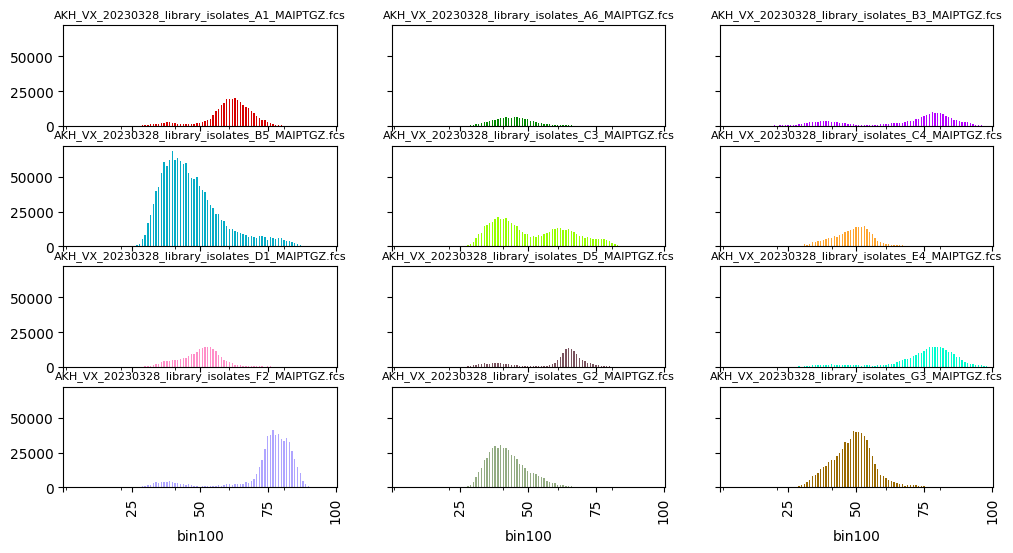

In [ ]:
colname_f1 = 'mCherry-A'
colname_f1_xform = '{}_xform'.format(colname_f1)
df[colname_f1_xform] = logicle_xform.apply(df[colname_f1])


bins = 100
figsize=(24,8)
height_ratios=(4,1)
color=palette12

ret_dmerged_03vv = DropletSorter.plot_histogram_highlighting_strains(
    df=df,
    colname_f1=colname_f1_xform,
    bins=bins,
    figsize=figsize,
    height_ratios=height_ratios,
    color=color,
    font_size='x-small',
    remove_legend=False,
)

figsize=(12, 6)
height_ratios=None #, #[1]*12
nrows=4
ncols=3
bins=100
ls_color=palette12

ret_dmerged_03vv_01 = DropletSorter.plot_histogram_strains_individual(
              df=ret_dmerged_03vv['df'],
              ls_sid=ls_wz,
              bins=bins,
              ls_color=ls_color,
              figsize=figsize,
              nrows=nrows,
              ncols=ncols,
              ylim=None,
              fontsize=10,
              size_title=8,
              )